# Планирование рекламных кампаний

Цель проекта: Построить прогностическую модель для рейтинга рекламных блоков, для более оптимального планирования рекламных кампаний.

Задание ограничено 1 телеканалом и 10 его регулярными телепрограммами.

**Задачи:**

Генерация признаков на основе предоставленных данных. Определение и оценка значимости факторов, влияющих на телесмотрение блока.

Подбор оптимального алгоритма модели, используя методы машинное обучения и подбора гиперпараметров  (gridsearchcv и аналогичные)

**Предоставляемые данные**

Исторические данные: Смотрение рекламных блоков — за 2023 год (январь-октябрь)

Данные для прогноза: Данные по выходам блоков за ноябрь 2023 без значений смотрения (его нужно спрогнозировать)

**Состав данных:**

- Дата
- ID
- Время начала блока
- Время окончания блока
- Время начала программы
- Телевизионная передача
- Категория телепередачи
- Жанр телепередачи
- Рейтинг (переменная, которую нужно спрогнозировать)

**Формат результатов:**

Прогноз смотрения рекламных блоков (далее он будет сверен с фактом) csv-формате.

# План решения

Для решения данной задачи будем использовать следующий алгоритм:

1. Загрузить исторические данные и данные для прогноза в pandas DataFrame.

Исторические данные: data
Данные для прогноза: november

2. Провести предобработку данных:

    a. Заполнить пропущенные значения в столбцах 'Начало блока', 'Окончание блока', 'Время начала программы', 'Телевизионная передача', 'Жанр передачи' и 'Рейтинг блока' средними значениями по столбцу (если таковые имеются).

    b. Преобразовать 'Дату' в формат datetime. (таких столбцов будет несколько)
    

3. Построить признаки на основе предоставленных данных:

    a. Вычислить следующие признаки:

        i. Длительность_сек (разница между 'Окончание блока' и 'Начало блока').

        ii. Месяц показа (потребуется для тестирования гипотезы о ненужности Января)

        iii. День недели

        iii. Определить длительность программы (потребуется ниже)

        v. Определить (создать новую колонку-признак) где показывался рекламный
        блок - в начале, середине или конце программы

        iv. Вычислить время суток показа передачи (день, ночь, утро, вечер)        

        vi Рейтинг предыдущего блока. (что нам это даст?

        vi. Рейтинг следующего блока. ( что нам это даст?)

        vii. Рейтинг в той же категории. (чей рейтинг? средний рейтинг по категории или что ?)

        viii. Рейтинг в том же жанре. (чей рейтинг? средний рейтинг по жанру или что ?)

    b. Отбросить нулевые значения в столбцах 'Начало блока', 'Окончание блока',
     'Время начала передачи', Категория передачи', 'Жанр передачи'
     и 'Рейтинг блока'.

    c. Перевести категориальные переменные в числовые столбцы

    d. Подключить датасет color (признак праздничного дня)

4. Разделить DataFrame на обучающую и тестовую выборки (у нас 80% на 20%).

5. Обучить модель с помощью алгоритмов машинного обучения (Линейная регрессия, Lasso, Random Forest, CatBoost).

6. Оценить качество модели на тестовой выборке (например, с помощью функции score).

7. Загрузить данные для прогноза

8. Подготовить данные для прогноза (заполнить пропущенные значения, преобразовать 'Дату' в формат datetime и т.д.).

9. Добавить и рассчитать дополнительные признаки-колонки

10. Прогнать обученную модель на данных для прогноза и получить прогноз смотрения рекламных блоков.

11. Сохранить прогноз в csv-формате.

# Начало кода


## Импорт библиотек


In [ ]:
#Импорт библиотек

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as datetime

# из библиотеки google.colab импортируем класс files
from google.colab import files

#drive.mount('/content/drive')

#Импорт моделей
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingClassifier
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error



from sklearn.model_selection import GridSearchCV


from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', 200)


# Важно как-то посчитать длительность передачи. у нас будет только время ее начала
# зная длительность, можно посчитать где был баннер показан - в начале, середине или конце программы
# можно заюзать другие метрике - MAE RSME  - они дают ошибку в единицах таргет

## Описательная статистика датасета data и november


In [ ]:
# Этот код выводит информацию о размере и типах данных в датасете, описательную статистику и количество пропусков.
# Затем он строит графики распределения признаков и целевой переменной, а также корреляционную матрицу.
# Эти графики могут помочь лучше понять данные и выявить потенциальные проблемы, такие как выбросы или сильную корреляцию между признаками.


# Загрузка данных
try:
  data = pd.read_csv('train_data.csv', sep=';')
except FileNotFoundError:
  #data = pd.read_excel('https://hr-portal.ru/files/train_data2.xlsx')
  data = pd.read_excel('https://hr-portal.ru/files/my_train.xlsx')
data

TVR Index       Date  Break flight ID   Break flight start  \
0       0.614693 2023-01-02       4870830561             08:17:33   
1       0.869565 2023-01-02       4870830614             08:34:45   
2       0.989505 2023-01-02       4870830629             08:52:19   
3       0.884558 2023-01-02       4870830684             08:56:31   
4       0.839580 2023-01-02       4870830685             09:12:04   
...          ...        ...              ...                  ...   
30677   0.029985 2023-10-31       5335333196  1900-01-01 03:43:40   
30678   0.029985 2023-10-31       5335333197  1900-01-01 03:44:07   
30679   0.014993 2023-10-31       5335333212  1900-01-01 04:02:10   
30680   0.029985 2023-10-31       5335333228  1900-01-01 04:26:20   
30681   0.044978 2023-10-31       5335333243  1900-01-01 04:41:09   

          Break flight end Break content Break distribution  \
0                 08:21:40    Commercial            Network   
1                 08:38:52    Commercial            Network   
2                 08:56:23    Commercial            Network   
3                 08:57:28  Announcement            Network   
4                 09:16:13    Commercial            Network   
...                    ...           ...                ...   
30677  1900-01-01 03:44:07  Announcement            Network   
30678  1900-01-01 03:48:13    Commercial            Network   
30679  1900-01-01 04:06:16    Commercial            Network   
30680  1900-01-01 04:30:25    Commercial            Network   
30681  1900-01-01 04:45:14    Commercial            Network   

                     Programme Programme flight start Programme flight end  \
0      Telekanal "Dobroe utro"               08:00:13             10:00:14   
1      Telekanal "Dobroe utro"               08:00:13             10:00:14   
2      Telekanal "Dobroe utro"               08:00:13             10:00:14   
3      Telekanal "Dobroe utro"               08:00:13             10:00:14   
4      Telekanal "Dobroe utro"               08:00:13             10:00:14   
...                        ...                    ...                  ...   
30677              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
30678              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
30679              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
30680              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   
30681              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   

            Programme category         Programme genre  
0              Morning airplay  Entertainment programs  
1              Morning airplay  Entertainment programs  
2              Morning airplay  Entertainment programs  
3              Morning airplay  Entertainment programs  
4              Morning airplay  Entertainment programs  
...                        ...                     ...  
30677  Entertainment talk show  Entertainment programs  
30678  Entertainment talk show  Entertainment programs  
30679  Entertainment talk show  Entertainment programs  
30680  Entertainment talk show  Entertainment programs  
30681  Entertainment talk show  Entertainment programs  

[30682 rows x 12 columns]

In [ ]:
try:
  november = pd.read_csv('test_data.xlsx')
except:
  november = pd.read_excel('https://hr-portal.ru/files/my_test.xlsx')
  #november = pd.read_excel('https://hr-portal.ru/files/test_data.xlsx')
november

Date  Break flight ID   Break flight start     Break flight end  \
0    2023-11-01       5336499245             05:18:36             05:19:07   
1    2023-11-01       5336499246             05:25:51             05:27:00   
2    2023-11-01       5336499251             05:49:11             05:50:04   
3    2023-11-01       5336499255             06:09:24             06:12:29   
4    2023-11-01       5336499270             06:12:35             06:13:46   
...         ...              ...                  ...                  ...   
3324 2023-11-30       5388713473  1900-01-01 03:52:44  1900-01-01 03:56:50   
3325 2023-11-30       5388713485  1900-01-01 04:08:22  1900-01-01 04:08:37   
3326 2023-11-30       5388713486  1900-01-01 04:08:37  1900-01-01 04:12:42   
3327 2023-11-30       5388713500  1900-01-01 04:24:51  1900-01-01 04:28:56   
3328 2023-11-30       5388713513  1900-01-01 04:33:17  1900-01-01 04:37:22   

     Break content Break distribution                Programme  \
0     Announcement            Network  Telekanal "Dobroe utro"   
1     Announcement            Network  Telekanal "Dobroe utro"   
2     Announcement            Network  Telekanal "Dobroe utro"   
3       Commercial            Network  Telekanal "Dobroe utro"   
4     Announcement            Network  Telekanal "Dobroe utro"   
...            ...                ...                      ...   
3324    Commercial            Network              Podkast.Lab   
3325  Announcement            Network              Podkast.Lab   
3326    Commercial            Network              Podkast.Lab   
3327    Commercial            Network              Podkast.Lab   
3328    Commercial            Network              Podkast.Lab   

     Programme flight start Programme flight end       Programme category  \
0                  05:06:18             05:30:15          Morning airplay   
1                  05:06:18             05:30:15          Morning airplay   
2                  05:36:16             06:00:15          Morning airplay   
3                  06:06:19             06:30:15          Morning airplay   
4                  06:06:19             06:30:15          Morning airplay   
...                     ...                  ...                      ...   
3324    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3325    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3326    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3327    1900-01-01 04:12:42  1900-01-01 04:56:34  Entertainment talk show   
3328    1900-01-01 04:12:42  1900-01-01 04:56:34  Entertainment talk show   

             Programme genre  TVR Index Forecast  
0     Entertainment programs                 NaN  
1     Entertainment programs                 NaN  
2     Entertainment programs                 NaN  
3     Entertainment programs                 NaN  
4     Entertainment programs                 NaN  
...                      ...                 ...  
3324  Entertainment programs                 NaN  
3325  Entertainment programs                 NaN  
3326  Entertainment programs                 NaN  
3327  Entertainment programs                 NaN  
3328  Entertainment programs                 NaN  

[3329 rows x 12 columns]

In [ ]:
# november = november.drop('TVR Index', axis=1)
# november['TVR Index'] = 1  # np.nan
# Изменение порядка столбцов
#df = df[['профессия', 'столбец2', 'столбец3', 'столбец4']]


#У меня затеcалась не пустая колонка Рейтинг, ее быть не должно,
#но удалять и создавать ее  - она встанет в конец - потом опять ее перекидывать туда-сюда.
#Пусть пока болтается



In [ ]:
# graph = sns.pairplot(data.drop(columns=['TVR Index']))
# graph.fig.set_size_inches(8, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30682 entries, 0 to 30681
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TVR Index               30682 non-null  float64       
 1   Date                    30682 non-null  datetime64[ns]
 2   Break flight ID         30682 non-null  int64         
 3   Break flight start      30682 non-null  object        
 4   Break flight end        30682 non-null  object        
 5   Break content           30682 non-null  object        
 6   Break distribution      30682 non-null  object        
 7   Programme               30682 non-null  object        
 8   Programme flight start  30682 non-null  object        
 9   Programme flight end    30682 non-null  object        
 10  Programme category      30682 non-null  object        
 11  Programme genre         30682 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), ob

Визуализация пропущенных данных

In [ ]:
#import seaborn as sns
#columns = data.columns
# определяем цвета
# второй цвет - пропуски (в данный момент мажента)
#colours = ['#e2e2e2', '#ff00ff']
#sns.heatmap(data[columns].isnull(), cmap=sns.color_palette(colours))

In [ ]:
november.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    3329 non-null   datetime64[ns]
 1   Break flight ID         3329 non-null   int64         
 2   Break flight start      3329 non-null   object        
 3   Break flight end        3329 non-null   object        
 4   Break content           3329 non-null   object        
 5   Break distribution      3329 non-null   object        
 6   Programme               3329 non-null   object        
 7   Programme flight start  3329 non-null   object        
 8   Programme flight end    3329 non-null   object        
 9   Programme category      3329 non-null   object        
 10  Programme genre         3329 non-null   object        
 11  TVR Index Forecast      0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), obje

Переставим колонку у Новебмер

In [ ]:
november = november.reindex(columns=november.columns)

november

Date  Break flight ID   Break flight start     Break flight end  \
0    2023-11-01       5336499245             05:18:36             05:19:07   
1    2023-11-01       5336499246             05:25:51             05:27:00   
2    2023-11-01       5336499251             05:49:11             05:50:04   
3    2023-11-01       5336499255             06:09:24             06:12:29   
4    2023-11-01       5336499270             06:12:35             06:13:46   
...         ...              ...                  ...                  ...   
3324 2023-11-30       5388713473  1900-01-01 03:52:44  1900-01-01 03:56:50   
3325 2023-11-30       5388713485  1900-01-01 04:08:22  1900-01-01 04:08:37   
3326 2023-11-30       5388713486  1900-01-01 04:08:37  1900-01-01 04:12:42   
3327 2023-11-30       5388713500  1900-01-01 04:24:51  1900-01-01 04:28:56   
3328 2023-11-30       5388713513  1900-01-01 04:33:17  1900-01-01 04:37:22   

     Break content Break distribution                Programme  \
0     Announcement            Network  Telekanal "Dobroe utro"   
1     Announcement            Network  Telekanal "Dobroe utro"   
2     Announcement            Network  Telekanal "Dobroe utro"   
3       Commercial            Network  Telekanal "Dobroe utro"   
4     Announcement            Network  Telekanal "Dobroe utro"   
...            ...                ...                      ...   
3324    Commercial            Network              Podkast.Lab   
3325  Announcement            Network              Podkast.Lab   
3326    Commercial            Network              Podkast.Lab   
3327    Commercial            Network              Podkast.Lab   
3328    Commercial            Network              Podkast.Lab   

     Programme flight start Programme flight end       Programme category  \
0                  05:06:18             05:30:15          Morning airplay   
1                  05:06:18             05:30:15          Morning airplay   
2                  05:36:16             06:00:15          Morning airplay   
3                  06:06:19             06:30:15          Morning airplay   
4                  06:06:19             06:30:15          Morning airplay   
...                     ...                  ...                      ...   
3324    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3325    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3326    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3327    1900-01-01 04:12:42  1900-01-01 04:56:34  Entertainment talk show   
3328    1900-01-01 04:12:42  1900-01-01 04:56:34  Entertainment talk show   

             Programme genre  TVR Index Forecast  
0     Entertainment programs                 NaN  
1     Entertainment programs                 NaN  
2     Entertainment programs                 NaN  
3     Entertainment programs                 NaN  
4     Entertainment programs                 NaN  
...                      ...                 ...  
3324  Entertainment programs                 NaN  
3325  Entertainment programs                 NaN  
3326  Entertainment programs                 NaN  
3327  Entertainment programs                 NaN  
3328  Entertainment programs                 NaN  

[3329 rows x 12 columns]

In [ ]:
#data.hist(figsize=(20, 20));

In [ ]:
#november.hist(figsize=(20, 20));

Выведем описательную статистику

In [ ]:
data.describe()

TVR Index  Break flight ID
count  30682.000000     3.068200e+04
mean       1.003735     5.100496e+09
std        0.609931     1.338851e+08
min        0.000000     4.870831e+09
25%        0.584708     4.984457e+09
50%        0.944528     5.098226e+09
75%        1.334333     5.215397e+09
max        5.052474     5.335333e+09

In [ ]:
november.describe()

Break flight ID  TVR Index Forecast
count     3.329000e+03                 0.0
mean      5.363745e+09                 NaN
std       1.545706e+07                 NaN
min       5.336499e+09                 NaN
25%       5.351237e+09                 NaN
50%       5.363940e+09                 NaN
75%       5.376278e+09                 NaN
max       5.388714e+09                 NaN

In [ ]:
# Подсчет пропусков
print('Missing values:')
print(data.isnull().sum())


Missing values:
TVR Index                 0
Date                      0
Break flight ID           0
Break flight start        0
Break flight end          0
Break content             0
Break distribution        0
Programme                 0
Programme flight start    0
Programme flight end      0
Programme category        0
Programme genre           0
dtype: int64


Посчитаем NAN и отобразим в новой колонке (не забыв потом ее удалить)  - не стал этого делать, ниже проще код

In [ ]:
# data['% NaN'] = data.apply(lambda x: x.isnull().sum() / len(x), axis=1)
#data.head()

In [ ]:
# Еще один вариант
is_nan = data.isna().sum() / len(data) * 100
print("NaN values in Dataset")
print(is_nan[is_nan > 0].sort_values(ascending=False))

NaN values in Dataset
Series([], dtype: float64)


In [ ]:
#также может пригодится удаление значений (в исторических данных), если по ним нет данных в колонке "рейтинг"

# df.dropna(subset=['TVR Index'], inplace=True)

In [ ]:
# Подсчет пропусков november
print('Missing values:')
print(november.isnull().sum())

Missing values:
Date                         0
Break flight ID              0
Break flight start           0
Break flight end             0
Break content                0
Break distribution           0
Programme                    0
Programme flight start       0
Programme flight end         0
Programme category           0
Programme genre              0
TVR Index Forecast        3329
dtype: int64


In [ ]:
#november['% NaN'] = november.apply(lambda x: x.isnull().sum() / len(x), axis=1)
#data.head()

Изучение уникальных значений

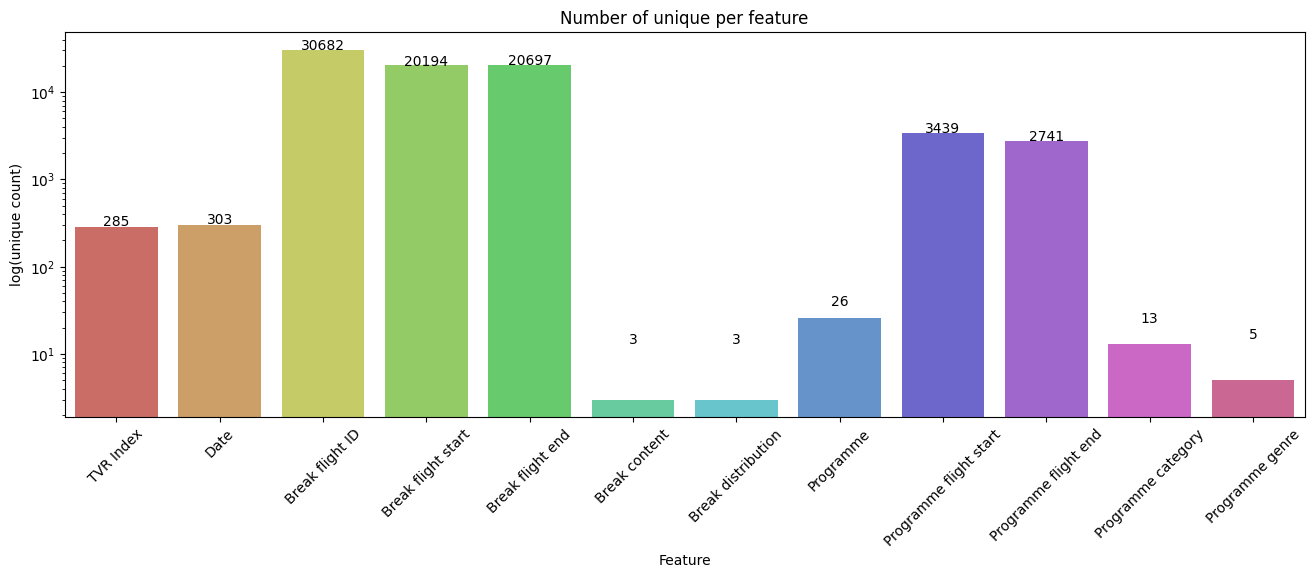

In [ ]:
plt.figure(figsize=(16, 5))

cols = data.columns
uniques = [len(data[col].unique()) for col in cols]

ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique per feature')


for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq + 10,
            uniq,
            ha="center")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

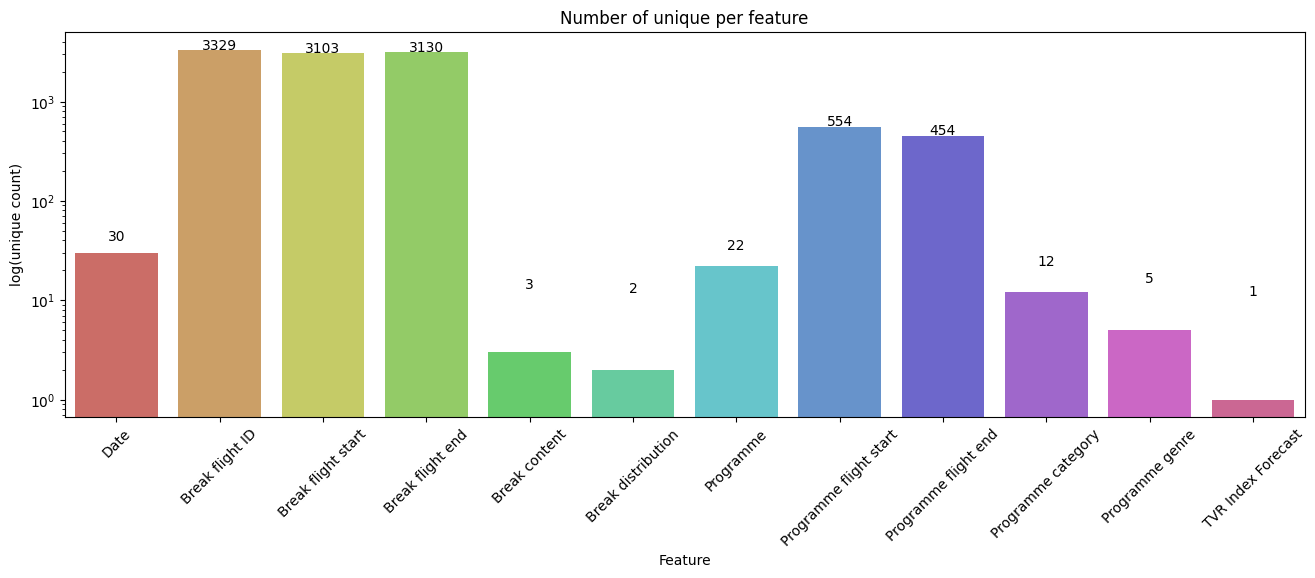

In [ ]:
plt.figure(figsize=(16, 5))

cols = november.columns
uniques = [len(november[col].unique()) for col in cols]

ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique per feature')


for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq + 10,
            uniq,
            ha="center")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Отдельно посмотрим распределение целевой переменной (после очистки от пропусков и NAN)

<Axes: >

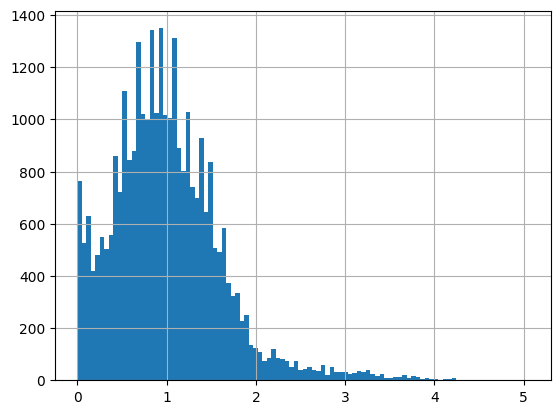

In [ ]:
data['TVR Index'].hist(bins=100)

### Посчитаем значения в категориальных переменных data & november

In [ ]:
data['Programme'].value_counts()

Telekanal "Dobroe utro"          7584
Vremya pokazhet                  5936
Bolshaya igra                    4194
Podkast.Lab                      2738
Muzhskoe/zhenskoe                1941
Zhit zdorovo                     1407
Kukly naslednika Tutti            758
AntiFeyk                          665
Videli video?                     558
Segodnya vecherom                 527
Pole Chudes                       476
Davay pozhenimsya!                473
Zdorovye                          430
Povara na kolesakh                330
Chelovek i Zakon                  323
Vremya                            295
Poekhali!                         274
Pro uyut                          251
Golos                             238
Tri akkorda                       203
Golos. Uzhe ne deti               203
Kto khochet stat millionerom?     194
Igray, Garmon!                    192
Vechernie novosti                 183
Dve zvezdy. Ottsy i deti          163
What? Where? When?                146
Name: Progra

In [ ]:
november['Programme'].value_counts()

Telekanal "Dobroe utro"          710
Podkast.Lab                      558
Vremya pokazhet                  429
Bolshaya igra                    399
Davay pozhenimsya!               246
Muzhskoe/zhenskoe                225
Zhit zdorovo                     155
Kukly naslednika Tutti            89
AntiFeyk                          84
Pole Chudes                       55
Zdorovye                          50
Segodnya vecherom                 50
Videli video?                     46
Vremya                            43
Chelovek i Zakon                  35
Pro uyut                          32
Kto khochet stat millionerom?     28
Poekhali!                         26
Povara na kolesakh                22
Vechernie novosti                 19
Igray, Garmon!                    18
What? Where? When?                10
Name: Programme, dtype: int64

In [ ]:
data['Programme category'].value_counts()

Socio-political talk show                  11553
Morning airplay                             7584
Entertainment talk show                     5679
Program on health                           1837
Quiz show, competition                      1257
Comic program                                558
Daily news                                   478
Mixed concert, show, circus performance      366
Program for women, Cookery show              330
Law and justice                              323
Geography and countries                      274
Program on fashion and design                251
Folk music and dances                        192
Name: Programme category, dtype: int64

In [ ]:
november['Programme category'].value_counts()

Entertainment talk show            1079
Socio-political talk show          1001
Morning airplay                     710
Program on health                   205
Quiz show, competition               93
Daily news                           62
Comic program                        46
Law and justice                      35
Program on fashion and design        32
Geography and countries              26
Program for women, Cookery show      22
Folk music and dances                18
Name: Programme category, dtype: int64

In [ ]:
data['Programme genre'].value_counts()

Entertainment programs       16025
Social-political programs    11876
Educational program           2111
News                           478
Musical programs               192
Name: Programme genre, dtype: int64

In [ ]:
november['Programme genre'].value_counts()

Entertainment programs       1982
Social-political programs    1036
Educational program           231
News                           62
Musical programs               18
Name: Programme genre, dtype: int64

In [ ]:
data['Break flight ID'].value_counts()
# много ID баннеров

4870830561    1
5173282261    1
5173282319    1
5173282318    1
5173282316    1
             ..
5022390470    1
5022390468    1
5022390467    1
5022390464    1
5335333243    1
Name: Break flight ID, Length: 30682, dtype: int64

In [ ]:
november['Break flight ID'].value_counts()
# много ID баннеров

5336499245    1
5363939925    1
5372686452    1
5372686455    1
5372686457    1
             ..
5355114153    1
5355114154    1
5355114174    1
5355114192    1
5388713513    1
Name: Break flight ID, Length: 3329, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30682 entries, 0 to 30681
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TVR Index               30682 non-null  float64       
 1   Date                    30682 non-null  datetime64[ns]
 2   Break flight ID         30682 non-null  int64         
 3   Break flight start      30682 non-null  object        
 4   Break flight end        30682 non-null  object        
 5   Break content           30682 non-null  object        
 6   Break distribution      30682 non-null  object        
 7   Programme               30682 non-null  object        
 8   Programme flight start  30682 non-null  object        
 9   Programme flight end    30682 non-null  object        
 10  Programme category      30682 non-null  object        
 11  Programme genre         30682 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), ob

In [ ]:
#bd = data['Programme flight start2'] = '1900-01-01 00:08:13'
#bd

###Посчитаем длительность показа РБ отдельно для Data и November


In [ ]:
# заполним колонку с человеческой датой-временем
def fun1(row, name_col, only_date = False):
    date_main = row['Date']
    date_str = row[name_col]
    #
    if isinstance(date_str, datetime.datetime):
      new_datetime = date_main + datetime.timedelta(days = 1, hours = date_str.time().hour, minutes = date_str.time().minute, seconds = date_str.time().second)
      #print(new_datetime)
    elif isinstance(date_str, datetime.time):
      new_datetime = date_main + datetime.timedelta(hours = date_str.hour, minutes = date_str.minute, seconds = date_str.second)
      #print(new_datetime)
    else:
      print('ERROR!')
    if only_date == True:
      new_datetime = datetime.datetime.combine(new_datetime, datetime.time(0))
    return new_datetime

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30682 entries, 0 to 30681
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TVR Index               30682 non-null  float64       
 1   Date                    30682 non-null  datetime64[ns]
 2   Break flight ID         30682 non-null  int64         
 3   Break flight start      30682 non-null  object        
 4   Break flight end        30682 non-null  object        
 5   Break content           30682 non-null  object        
 6   Break distribution      30682 non-null  object        
 7   Programme               30682 non-null  object        
 8   Programme flight start  30682 non-null  object        
 9   Programme flight end    30682 non-null  object        
 10  Programme category      30682 non-null  object        
 11  Programme genre         30682 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), ob

In [ ]:
# Переведем даты в дейтайм  (тут еще вопрос в каком формате будут даты)
# data['Date2'] = pd.to_datetime(data['Date2'], format='%Y-%m-%d')

#data['Break flight start2'] = pd.to_datetime(data['Break flight start'], format='%H:%M:%S') #закомментил Антон
data['Break flight start2'] = data.apply(fun1, axis = 1, args=('Break flight start',)) #добавил Антон
data['Break flight end2'] = data.apply(fun1, axis = 1, args=('Break flight end',)) #добавил Антон
#data['Break flight_time'] = pd.to_datetime(data['Break flight_time'], format='%H:%M:%S') #закомментил Антон

# Дата начала программы
#data['Programme flight start2'] = pd.to_datetime(data['Programme flight start'], format='%H:%M:%S')  #закомментил Антон
data['Programme flight start2'] = data.apply(fun1, axis = 1, args=('Programme flight start',)) #добавил Антон
data['Programme flight end2'] = data.apply(fun1, axis = 1, args=('Programme flight end',)) #добавил Антон

# Подсчитываем количество секунд у баннера  (это  будет инт)
#data['Длительность_сек'] = (data['Break flight_time'].dt.minute) *60 + (data['Break flight_time'].dt.second)
data['Длительность_сек']  = (data['Break flight end2'] - data['Break flight start2'])
data['Длительность_сек'] = data['Длительность_сек'].apply(lambda x: x.total_seconds())

#Аналогично переведем в дейтайм и время длительности программы
#data['Programme flight_time'] = pd.to_datetime(data['Programme flight_time'], format='%H:%M:%S')  #закомментил Антон

# Подсчитываем количество секунд у программы  (это  будет инт)
#data['Программ_сек'] = (data['Programme flight_time'].dt.minute) *60 + (data['Programme flight_time'].dt.second) #закомментил Антон
data['Программ_сек']  = (data['Programme flight end2'] - data['Programme flight start2'])
data['Программ_сек'] = data['Программ_сек'].apply(lambda x: x.total_seconds())


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30682 entries, 0 to 30681
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR Index                30682 non-null  float64       
 1   Date                     30682 non-null  datetime64[ns]
 2   Break flight ID          30682 non-null  int64         
 3   Break flight start       30682 non-null  object        
 4   Break flight end         30682 non-null  object        
 5   Break content            30682 non-null  object        
 6   Break distribution       30682 non-null  object        
 7   Programme                30682 non-null  object        
 8   Programme flight start   30682 non-null  object        
 9   Programme flight end     30682 non-null  object        
 10  Programme category       30682 non-null  object        
 11  Programme genre          30682 non-null  object        
 12  Break flight start2      30682 n

In [ ]:
# data['Длительность_сек'] = (pd.to_timedelta(data['Break flight_time']).astype('int64') / pd.Timedelta(seconds=1)).astype('int64')
# data['Длительность_сек'] = data['Break flight_time'].astype('int64')

# Извлекаем минуты и секунды
# data['minutes'] = data['Break flight_time'].dt.minute
# data['seconds'] = data['Break flight_time'].dt.second




In [ ]:
# data['Время_конца'] = pd.to_datetime(data['Время_конца'], format='%Y-%m-%d %H:%M:%S')
# время конца потом удалим, но пока надо для расчета длительности показа рекламного блока

# Считаем длительность рекламного блока и конвертируем ее в int в новой переменной
# data['Break flight_time'] = data['Время_конца'] - data['Break flight start2']

#data['Длительность_сек'] = data['Break flight_time'].astype(int)



In [ ]:
data.head(120)

/usr/local/lib/python3.10/dist-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


TVR Index       Date  Break flight ID   Break flight start  \
0     0.614693 2023-01-02       4870830561             08:17:33   
1     0.869565 2023-01-02       4870830614             08:34:45   
2     0.989505 2023-01-02       4870830629             08:52:19   
3     0.884558 2023-01-02       4870830684             08:56:31   
4     0.839580 2023-01-02       4870830685             09:12:04   
5     0.494753 2023-01-02       4870830703             09:16:19   
6     0.839580 2023-01-02       4870830704             09:28:40   
7     0.839580 2023-01-02       4870830719             09:43:01   
8     0.644678 2023-01-02       4870830735             09:47:17   
9     1.424288 2023-01-02       4870830778             11:21:26   
10    1.424288 2023-01-02       4870830780             11:21:36   
11    1.394303 2023-01-02       4870830781             11:21:47   
12    0.929535 2023-01-02       4870830790             11:23:38   
13    0.959520 2023-01-02       4870830794             11:24:44   
14    0.914543 2023-01-02       4870830797             11:46:12   
15    1.484258 2023-01-02       4870830798             11:46:53   
16    1.064468 2023-01-02       4870830808             11:49:02   
17    1.019490 2023-01-02       4870830812             11:50:08   
18    2.293853 2023-01-02       4871151428             12:28:23   
19    1.649175 2023-01-02       4871151430             12:28:34   
20    1.649175 2023-01-02       4871151432             12:29:56   
21    2.083958 2023-01-02       4871151433             12:30:06   
22    2.128936 2023-01-02       4871151452             12:43:20   
23    1.859070 2023-01-02       4871151454             12:44:16   
24    1.799100 2023-01-02       4871151455             12:44:26   
25    1.289355 2023-01-02       4871151462             12:46:24   
26    1.574213 2023-01-02       4871151467             12:47:30   
27    1.574213 2023-01-02       4871151470             12:48:30   
28    1.769115 2023-01-02       4871151473             13:02:56   
29    1.934033 2023-01-02       4871151474             13:03:38   
30    1.679160 2023-01-02       4871151494             13:36:55   
31    1.619190 2023-01-02       4871151496             13:37:27   
32    1.604198 2023-01-02       4871151497             13:37:42   
33    1.214393 2023-01-02       4871151505             13:39:37   
34    1.214393 2023-01-02       4871151511             13:40:42   
35    1.214393 2023-01-02       4871151515             14:04:44   
36    0.674663 2023-01-02       4871151517             14:06:04   
37    1.289355 2023-01-02       4871151518             14:07:05   
38    1.484258 2023-01-02       4871408292             22:46:11   
39    1.604198 2023-01-02       4871408294             23:09:14   
40    1.619190 2023-01-02       4871408296             23:10:17   
41    1.514243 2023-01-02       4871408297             23:10:27   
42    1.184408 2023-01-02       4871408310             23:36:24   
43    1.514243 2023-01-02       4871408312             23:37:06   
44    1.499250 2023-01-02       4871408313             23:37:16   
45    0.839580 2023-01-02       4871408321             23:39:15   
46    0.869565 2023-01-02       4871408328             23:40:21   
47    0.974513 2023-01-02       4871408332             23:54:07   
48    1.424288 2023-01-02       4871408333             23:55:09   
49    1.454273 2023-01-02       4871408345             23:59:14   
50    1.364318 2023-01-02       4871408347  1900-01-01 00:12:56   
51    1.319340 2023-01-02       4871408348  1900-01-01 00:14:00   
52    1.289355 2023-01-02       4871408350  1900-01-01 00:14:16   
53    0.734633 2023-01-02       4871408366  1900-01-01 00:48:26   
54    0.644678 2023-01-02       4871408367  1900-01-01 00:49:22   
55    0.659670 2023-01-02       4871414664  1900-01-01 01:08:33   
56    0.524738 2023-01-02       4871414666  1900-01-01 01:31:03   
57    0.434783 2023-01-02       4871414667  1900-01-01 01:31:27   
58    0.194903 2023-01-02       4871414681  1900-01-

Аналогично надо перевести даты и у November

In [ ]:
# Переведем даты в дейтайм  (тут еще вопрос в каком формате будут даты)
# november['Date2'] = pd.to_datetime(november['Date2'], format='%Y-%m-%d')
#november['Break flight start2'] = pd.to_datetime(november['Break flight start2'], format='%H:%M:%S')
#november['Break flight_time'] = pd.to_datetime(november['Break flight_time'], format='%H:%M:%S')

# Подсчитываем количество секунд у баннера  (это  будет инт)
#november['Длительность_сек'] = (november['Break flight_time'].dt.minute) *60 + (november['Break flight_time'].dt.second)

#Аналогично переведем в дейтайм и время длительности программы
#november['Programme flight_time'] = pd.to_datetime(november['Programme flight_time'], format='%H:%M:%S')


# Дата начала программы
#november['Programme flight start2'] = pd.to_datetime(november['Programme flight start2'], format='%H:%M:%S')

# Подсчитываем количество секунд у программы  (это  будет инт)
#november['Программ_сек'] = (november['Programme flight_time'].dt.minute) *60 + (november['Programme flight_time'].dt.second)



# Переведем даты в дейтайм  (тут еще вопрос в каком формате будут даты)
november['Break flight start2'] = november.apply(fun1, axis = 1, args=('Break flight start',)) #добавил Антон
november['Break flight end2'] = november.apply(fun1, axis = 1, args=('Break flight end',)) #добавил Антон

# Дата начала программы
november['Programme flight start2'] = november.apply(fun1, axis = 1, args=('Programme flight start',)) #добавил Антон
november['Programme flight end2'] = november.apply(fun1, axis = 1, args=('Programme flight end',)) #добавил Антон

# Подсчитываем количество секунд у баннера  (это  будет инт)
november['Длительность_сек']  = (november['Break flight end2'] - november['Break flight start2'])
november['Длительность_сек'] = november['Длительность_сек'].apply(lambda x: x.total_seconds())

# Подсчитываем количество секунд у программы  (это  будет инт)
november['Программ_сек']  = (november['Programme flight end2'] - november['Programme flight start2'])
november['Программ_сек'] = november['Программ_сек'].apply(lambda x: x.total_seconds())

november.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     3329 non-null   datetime64[ns]
 1   Break flight ID          3329 non-null   int64         
 2   Break flight start       3329 non-null   object        
 3   Break flight end         3329 non-null   object        
 4   Break content            3329 non-null   object        
 5   Break distribution       3329 non-null   object        
 6   Programme                3329 non-null   object        
 7   Programme flight start   3329 non-null   object        
 8   Programme flight end     3329 non-null   object        
 9   Programme category       3329 non-null   object        
 10  Programme genre          3329 non-null   object        
 11  TVR Index Forecast       0 non-null      float64       
 12  Break flight start2      3329 non-

In [ ]:
november


Date  Break flight ID   Break flight start     Break flight end  \
0    2023-11-01       5336499245             05:18:36             05:19:07   
1    2023-11-01       5336499246             05:25:51             05:27:00   
2    2023-11-01       5336499251             05:49:11             05:50:04   
3    2023-11-01       5336499255             06:09:24             06:12:29   
4    2023-11-01       5336499270             06:12:35             06:13:46   
...         ...              ...                  ...                  ...   
3324 2023-11-30       5388713473  1900-01-01 03:52:44  1900-01-01 03:56:50   
3325 2023-11-30       5388713485  1900-01-01 04:08:22  1900-01-01 04:08:37   
3326 2023-11-30       5388713486  1900-01-01 04:08:37  1900-01-01 04:12:42   
3327 2023-11-30       5388713500  1900-01-01 04:24:51  1900-01-01 04:28:56   
3328 2023-11-30       5388713513  1900-01-01 04:33:17  1900-01-01 04:37:22   

     Break content Break distribution                Programme  \
0     Announcement            Network  Telekanal "Dobroe utro"   
1     Announcement            Network  Telekanal "Dobroe utro"   
2     Announcement            Network  Telekanal "Dobroe utro"   
3       Commercial            Network  Telekanal "Dobroe utro"   
4     Announcement            Network  Telekanal "Dobroe utro"   
...            ...                ...                      ...   
3324    Commercial            Network              Podkast.Lab   
3325  Announcement            Network              Podkast.Lab   
3326    Commercial            Network              Podkast.Lab   
3327    Commercial            Network              Podkast.Lab   
3328    Commercial            Network              Podkast.Lab   

     Programme flight start Programme flight end       Programme category  \
0                  05:06:18             05:30:15          Morning airplay   
1                  05:06:18             05:30:15          Morning airplay   
2                  05:36:16             06:00:15          Morning airplay   
3                  06:06:19             06:30:15          Morning airplay   
4                  06:06:19             06:30:15          Morning airplay   
...                     ...                  ...                      ...   
3324    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3325    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3326    1900-01-01 03:24:15  1900-01-01 04:12:42  Entertainment talk show   
3327    1900-01-01 04:12:42  1900-01-01 04:56:34  Entertainment talk show   
3328    1900-01-01 04:12:42  1900-01-01 04:56:34  Entertainment talk show   

             Programme genre  TVR Index Forecast Break flight start2  \
0     Entertainment programs                 NaN 2023-11-01 05:18:36   
1     Entertainment programs                 NaN 2023-11-01 05:25:51   
2     Entertainment programs                 NaN 2023-11-01 05:49:11   
3     Entertainment programs                 NaN 2023-11-01 06:09:24   
4     Entertainment programs                 NaN 2023-11-01 06:12:35   
...                      ...                 ...                 ...   
3324  Entertainment programs                 NaN 2023-12-01 03:52:44   
3325  Entertainment programs                 NaN 2023-12-01 04:08:22   
3326  Entertainment programs                 NaN 2023-12-01 04:08:37   
3327  Entertainment programs                 NaN 2023-12-01 04:24:51   
3328  Entertainment programs                 NaN 2023-12-01 04:33:17   

       Break flight end2 Programme flight start2 Programme flight end2  \
0    2023-11-01 05:19:07     2023-11-01 05:06:18   2023-11-01 05:30:15   
1    2023-11-01 05:27:00     2023-11-01 05:06:18   2023-11-01 05:30:15   
2    2023-11-01 05:50:04     2023-11-01 05:36:16   2023-11-01 06:00:15   
3    2023-11-01 06:12:29     2023-11-01 06:06:19   2023-11-01 06:30:15   
4    2023-11-01 06:13:46     2023-11-01 06:06:19   2023-11-01 06:30:15   
...                  ...                     ..

### Проверим на выбросы с помощью боксплот

count    30682.000000
mean         1.003735
std          0.609931
min          0.000000
25%          0.584708
50%          0.944528
75%          1.334333
max          5.052474
Name: TVR Index, dtype: float64

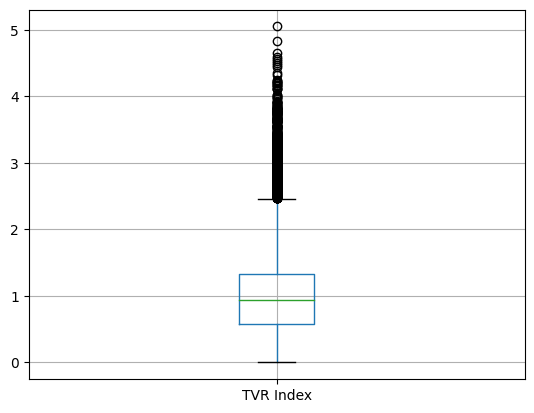

In [ ]:
data.loc[:,['TVR Index']].boxplot();
data['TVR Index'].describe()

count    30682.000000
mean        92.238218
std         74.999667
min          3.000000
25%         30.000000
50%         66.000000
75%        125.000000
max        398.000000
Name: Длительность_сек, dtype: float64

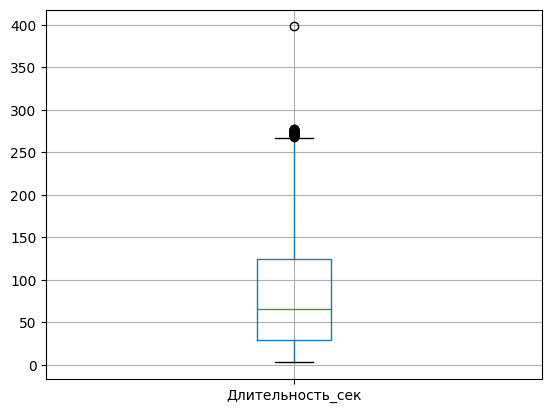

In [ ]:
data.loc[:,['Длительность_сек']].boxplot();
data['Длительность_сек'].describe()

Видимы выбросы примерно после 270. Может ли РБ столько показываться? не понятно

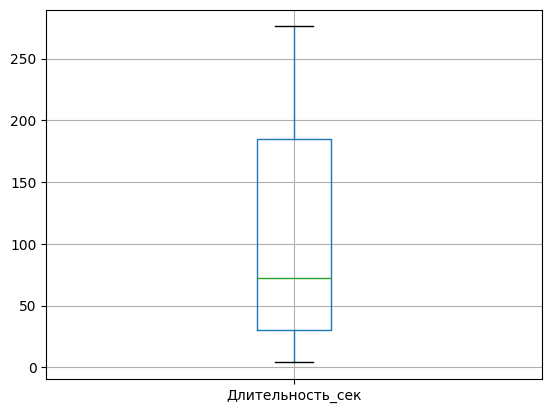

In [ ]:
november.loc[:,['Длительность_сек']].boxplot();

Возможно понадобится удалять выбросы у показателя "рейтинг" и у показателя время показа баннера (в исторических данных)

####  Удаляю нули из колонки Рейтинг из Train (data)


In [ ]:
# Сколько было данных
data.shape

(30682, 18)

In [ ]:
# Переименуем колонку
data = data.rename(columns={'TVR Index': 'TVR_Index'})
november = november.rename(columns={'TVR Index Forecast': 'TVR_Index'})

<Axes: >

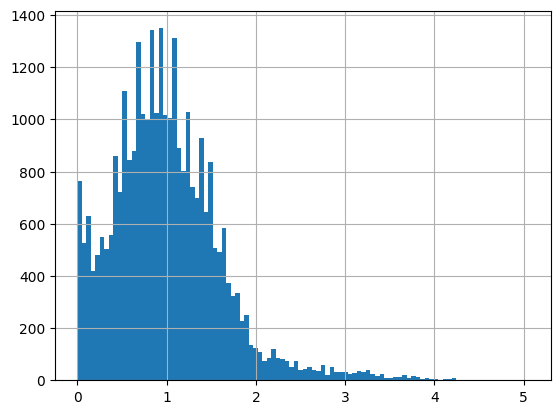

In [ ]:
data['TVR_Index'].hist(bins=100)

In [ ]:
# не работает
# len([data['TVR_Index'] != 0])

#Работает
counts = data['TVR_Index'].value_counts()
print(counts[0])

# когда вы используете data.query('TVR\_Index > 0'), вы фактически удаляете все строки,
#где 'TVR_Index' равен нулю или меньше нуля.
# Это может быть причиной того, что вы видите "очень много" строк, которые были удалены.
#data = data.query('TVR_Index > 0')




110


In [ ]:
data = data.drop(data[data['TVR_Index'] == 0].index)
data.shape

(30572, 18)

Тут в планах обрезать справа и слева по значению TVR_Index

<Axes: >

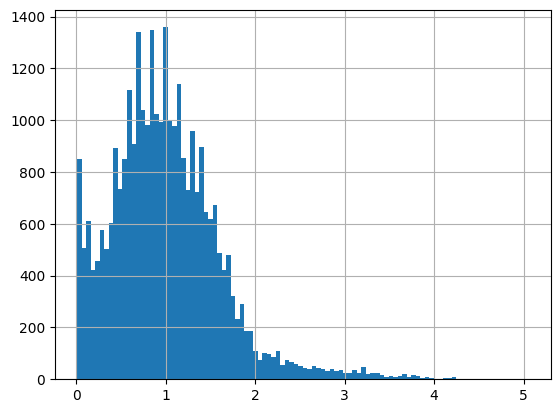

In [ ]:
data['TVR_Index'].hist(bins=100)

In [ ]:
# data = data.drop(data[data['TVR_Index'] < 0.3].index)
# data = data.drop(data[data['TVR_Index'] > 3].index)
data.shape

(30572, 18)

<Axes: >

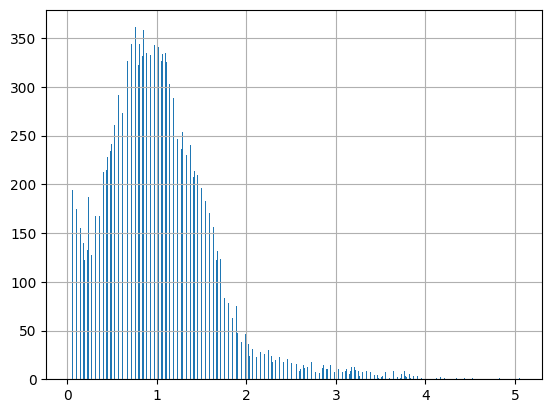

In [ ]:
data['TVR_Index'].hist(bins=1000)

In [ ]:
data['TVR_Index'].value_counts()

0.764618    361
0.854573    358
0.914543    354
0.989505    354
0.869565    352
           ... 
4.587706      1
4.437781      1
4.497751      1
3.928036      1
3.718141      1
Name: TVR_Index, Length: 284, dtype: int64

In [ ]:
## data = data.query('Рейтинг > 5 or Рейтинг < 95')
## data = data.query('Длительность_сек > 5 or Длительность_сек < 95')

In [ ]:
##Пример логарифмирования, просто, чтобы был

#df_train['price_log'] = np.log(df_train['price'] + 1)

#plt.figure(figsize=(12,5))

#g = sns.histplot(df_train['price_log'].dropna(), bins=50)
#g.set_xlabel('Price Log', fontsize=15)
#g.set_ylabel('Probility', fontsize=15)
#g.set_title("Price Histogram", fontsize=20);

#np.exp(5), np.exp(10) # - показывает значения реальные по границам логарифма

Колонка Месяц - добавим ее в общий датасет. Не буду использовать в качестве разделителя трейн и тест

In [ ]:
# Месяц у нас есть уже, но код для добавления
#data['month'] = pd.DatetimeIndex(data['Date2']).month
#november['month'] = pd.DatetimeIndex(november['Date2']).month

### Выводы по разделу

Тут будут выводы

## Создаем общий датасет

In [ ]:
print(data.shape)
print(november.shape)

(30572, 18)
(3329, 18)


Добавим новую колонку для дата и новембер, чтобы потом их можно было обратно поделить

> Блок с отступами



In [ ]:
data['type'] = 1
november['type'] = 0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30572 entries, 0 to 30681
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Date                     30572 non-null  datetime64[ns]
 2   Break flight ID          30572 non-null  int64         
 3   Break flight start       30572 non-null  object        
 4   Break flight end         30572 non-null  object        
 5   Break content            30572 non-null  object        
 6   Break distribution       30572 non-null  object        
 7   Programme                30572 non-null  object        
 8   Programme flight start   30572 non-null  object        
 9   Programme flight end     30572 non-null  object        
 10  Programme category       30572 non-null  object        
 11  Programme genre          30572 non-null  object        
 12  Break flight start2      30572 n

In [ ]:
november.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     3329 non-null   datetime64[ns]
 1   Break flight ID          3329 non-null   int64         
 2   Break flight start       3329 non-null   object        
 3   Break flight end         3329 non-null   object        
 4   Break content            3329 non-null   object        
 5   Break distribution       3329 non-null   object        
 6   Programme                3329 non-null   object        
 7   Programme flight start   3329 non-null   object        
 8   Programme flight end     3329 non-null   object        
 9   Programme category       3329 non-null   object        
 10  Programme genre          3329 non-null   object        
 11  TVR_Index                0 non-null      float64       
 12  Break flight start2      3329 non-

In [ ]:
#df_fullfull=df[df1.columns]
#df=pd.concat((df1,df2),axis=0)

In [ ]:
november.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     3329 non-null   datetime64[ns]
 1   Break flight ID          3329 non-null   int64         
 2   Break flight start       3329 non-null   object        
 3   Break flight end         3329 non-null   object        
 4   Break content            3329 non-null   object        
 5   Break distribution       3329 non-null   object        
 6   Programme                3329 non-null   object        
 7   Programme flight start   3329 non-null   object        
 8   Programme flight end     3329 non-null   object        
 9   Programme category       3329 non-null   object        
 10  Programme genre          3329 non-null   object        
 11  TVR_Index                0 non-null      float64       
 12  Break flight start2      3329 non-

In [ ]:
# data_all = pd.concat([data, november])
# data_all
november = november[data.columns]
data_all=pd.concat((data,november),axis=0)

In [ ]:
data_all.shape

(33901, 19)

### Описательная статистика общего датасета

In [ ]:
# Описательная статистика
print('data_all shape:', data_all.shape)
print()
print('Data summary statistics:')
print(data_all.describe())

data_all shape: (33901, 19)

Data summary statistics:
          TVR_Index  Break flight ID  Длительность_сек  Программ_сек  \
count  30572.000000     3.390100e+04      33901.000000  33901.000000   
mean       1.007346     5.126224e+09         93.736055   3163.838235   
std        0.608043     1.494078e+08         76.442778   1421.960078   
min        0.014993     4.870831e+09          3.000000    500.000000   
25%        0.599700     4.996265e+09         30.000000   2329.000000   
50%        0.944528     5.123467e+09         67.000000   3037.000000   
75%        1.334333     5.256221e+09        126.000000   4087.000000   
max        5.052474     5.388714e+09        398.000000  11193.000000   

               type  
count  33901.000000  
mean       0.901802  
std        0.297586  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  


## Добавляем признаки и меняем формат данных в объединенном датасете


In [ ]:
# Тут я колонку "Передача" сделал объектом на всякий случай, но скорее всего она и будет объектом
#data_all['Programme'] = data_all['Programme'].astype(object)

#data_all.info()

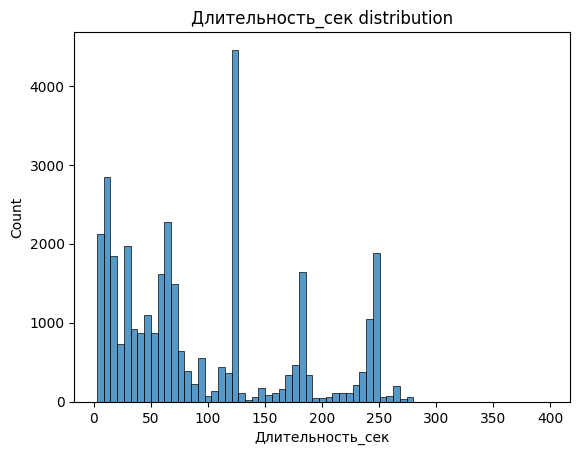

In [ ]:
# Графики распределения признаков
sns.histplot(data_all['Длительность_сек'], kde=False)
plt.title('Длительность_сек distribution')
plt.show()





### Джойним таблицу с праздничными днями  (color)

Выходные и Праздничные дни - 1, будни - 0

In [ ]:
try:
  # color = pd.read_csv('color.csv')
  color = pd.read_csv('color.csv', delimiter=';')

except:
  color = pd.read_csv('https://hr-portal.ru/files/color.csv', delimiter=';')
color.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Дата    335 non-null    object
 1   Color   335 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


In [ ]:
color.head()


Дата  Color
0  01.01.2023      1
1  02.01.2023      1
2  03.01.2023      1
3  04.01.2023      1
4  05.01.2023      1

In [ ]:
color['Color'].value_counts()

0    231
1    104
Name: Color, dtype: int64

In [ ]:
#  Переведем "день" у Color в формат даты
color['Дата'] = pd.to_datetime(color['Дата'], format='%d.%m.%Y')

In [ ]:
# Переименуем колонку Дата в Date2
color = color.rename(columns={'Дата': 'Date2'})
color


Date2  Color
0   2023-01-01      1
1   2023-01-02      1
2   2023-01-03      1
3   2023-01-04      1
4   2023-01-05      1
..         ...    ...
330 2023-11-27      0
331 2023-11-28      0
332 2023-11-29      0
333 2023-11-30      0
334 2023-12-01      0

[335 rows x 2 columns]

In [ ]:
data_all.head(10)

TVR_Index       Date  Break flight ID Break flight start Break flight end  \
0   0.614693 2023-01-02       4870830561           08:17:33         08:21:40   
1   0.869565 2023-01-02       4870830614           08:34:45         08:38:52   
2   0.989505 2023-01-02       4870830629           08:52:19         08:56:23   
3   0.884558 2023-01-02       4870830684           08:56:31         08:57:28   
4   0.839580 2023-01-02       4870830685           09:12:04         09:16:13   
5   0.494753 2023-01-02       4870830703           09:16:19         09:17:28   
6   0.839580 2023-01-02       4870830704           09:28:40         09:32:46   
7   0.839580 2023-01-02       4870830719           09:43:01         09:47:09   
8   0.644678 2023-01-02       4870830735           09:47:17         09:48:31   
9   1.424288 2023-01-02       4870830778           11:21:26         11:21:36   

  Break content Break distribution                Programme  \
0    Commercial            Network  Telekanal "Dobroe utro"   
1    Commercial            Network  Telekanal "Dobroe utro"   
2    Commercial            Network  Telekanal "Dobroe utro"   
3  Announcement            Network  Telekanal "Dobroe utro"   
4    Commercial            Network  Telekanal "Dobroe utro"   
5  Announcement            Network  Telekanal "Dobroe utro"   
6    Commercial            Network  Telekanal "Dobroe utro"   
7    Commercial            Network  Telekanal "Dobroe utro"   
8  Announcement            Network  Telekanal "Dobroe utro"   
9   Sponsorship            Network                 Pro uyut   

  Programme flight start Programme flight end             Programme category  \
0               08:00:13             10:00:14                Morning airplay   
1               08:00:13             10:00:14                Morning airplay   
2               08:00:13             10:00:14                Morning airplay   
3               08:00:13             10:00:14                Morning airplay   
4               08:00:13             10:00:14                Morning airplay   
5               08:00:13             10:00:14                Morning airplay   
6               08:00:13             10:00:14                Morning airplay   
7               08:00:13             10:00:14                Morning airplay   
8               08:00:13             10:00:14                Morning airplay   
9               11:07:57             12:00:06  Program on fashion and design   

          Programme genre Break flight start2   Break flight end2  \
0  Entertainment programs 2023-01-02 08:17:33 2023-01-02 08:21:40   
1  Entertainment programs 2023-01-02 08:34:45 2023-01-02 08:38:52   
2  Entertainment programs 2023-01-02 08:52:19 2023-01-02 08:56:23   
3  Entertainment programs 2023-01-02 08:56:31 2023-01-02 08:57:28   
4  Entertainment programs 2023-01-02 09:12:04 2023-01-02 09:16:13   
5  Entertainment programs 2023-01-02 09:16:19 2023-01-02 09:17:28   
6  Entertainment programs 2023-01-02 09:28:40 2023-01-02 09:32:46   
7  Entertainment programs 2023-01-02 09:43:01 2023-01-02 09:47:09   
8  Entertainment programs 2023-01-02 09:47:17 2023-01-02 09:48:31   
9  Entertainment programs 2023-01-02 11:21:26 2023-01-02 11:21:36   

  Programme flight start2 Programme flight end2  Длительность_сек  \
0     2023-01-02 08:00:13   2023-01-02 10:00:14             247.0   
1     2023-01-02 08:00:13   2023-01-02 10:00:14             247.0   
2     2023-01-02 08:00:13   2023-01-02 10:00:14             244.0   
3     2023-01-02 08:00:13   2023-01-02 10:00:14              57.0   
4     2023-01-02 08:00:13   2023-01-02 10:00:14             249.0   
5     2023-01-02 08:00:13   2023-01-02 10:00:14              69.0   
6     2023-01-02 08:00:13   2023-01-02 10:00:14             246.0   
7     2023-01-02 08:00:13   2023-01-02 10:00:14             248.0   
8     2023-01-02 08:00:13   2023-01-02 10:00:14              74.0   
9     2023-01-02 11:07:57   2023-01-02 12:00:06              10.0   

   Программ_сек  type  
0  

In [ ]:
# Антон: т.к. стараемся уйти от предварительных действий в Excel, сгенерируем Date2 для data_all
data_all['Date2'] = data.apply(fun1, axis = 1, args=('Programme flight start2', True))
data_all.head(120)

TVR_Index       Date  Break flight ID   Break flight start  \
0     0.614693 2023-01-02       4870830561             08:17:33   
1     0.869565 2023-01-02       4870830614             08:34:45   
2     0.989505 2023-01-02       4870830629             08:52:19   
3     0.884558 2023-01-02       4870830684             08:56:31   
4     0.839580 2023-01-02       4870830685             09:12:04   
5     0.494753 2023-01-02       4870830703             09:16:19   
6     0.839580 2023-01-02       4870830704             09:28:40   
7     0.839580 2023-01-02       4870830719             09:43:01   
8     0.644678 2023-01-02       4870830735             09:47:17   
9     1.424288 2023-01-02       4870830778             11:21:26   
10    1.424288 2023-01-02       4870830780             11:21:36   
11    1.394303 2023-01-02       4870830781             11:21:47   
12    0.929535 2023-01-02       4870830790             11:23:38   
13    0.959520 2023-01-02       4870830794             11:24:44   
14    0.914543 2023-01-02       4870830797             11:46:12   
15    1.484258 2023-01-02       4870830798             11:46:53   
16    1.064468 2023-01-02       4870830808             11:49:02   
17    1.019490 2023-01-02       4870830812             11:50:08   
18    2.293853 2023-01-02       4871151428             12:28:23   
19    1.649175 2023-01-02       4871151430             12:28:34   
20    1.649175 2023-01-02       4871151432             12:29:56   
21    2.083958 2023-01-02       4871151433             12:30:06   
22    2.128936 2023-01-02       4871151452             12:43:20   
23    1.859070 2023-01-02       4871151454             12:44:16   
24    1.799100 2023-01-02       4871151455             12:44:26   
25    1.289355 2023-01-02       4871151462             12:46:24   
26    1.574213 2023-01-02       4871151467             12:47:30   
27    1.574213 2023-01-02       4871151470             12:48:30   
28    1.769115 2023-01-02       4871151473             13:02:56   
29    1.934033 2023-01-02       4871151474             13:03:38   
30    1.679160 2023-01-02       4871151494             13:36:55   
31    1.619190 2023-01-02       4871151496             13:37:27   
32    1.604198 2023-01-02       4871151497             13:37:42   
33    1.214393 2023-01-02       4871151505             13:39:37   
34    1.214393 2023-01-02       4871151511             13:40:42   
35    1.214393 2023-01-02       4871151515             14:04:44   
36    0.674663 2023-01-02       4871151517             14:06:04   
37    1.289355 2023-01-02       4871151518             14:07:05   
38    1.484258 2023-01-02       4871408292             22:46:11   
39    1.604198 2023-01-02       4871408294             23:09:14   
40    1.619190 2023-01-02       4871408296             23:10:17   
41    1.514243 2023-01-02       4871408297             23:10:27   
42    1.184408 2023-01-02       4871408310             23:36:24   
43    1.514243 2023-01-02       4871408312             23:37:06   
44    1.499250 2023-01-02       4871408313             23:37:16   
45    0.839580 2023-01-02       4871408321             23:39:15   
46    0.869565 2023-01-02       4871408328             23:40:21   
47    0.974513 2023-01-02       4871408332             23:54:07   
48    1.424288 2023-01-02       4871408333             23:55:09   
49    1.454273 2023-01-02       4871408345             23:59:14   
50    1.364318 2023-01-02       4871408347  1900-01-01 00:12:56   
51    1.319340 2023-01-02       4871408348  1900-01-01 00:14:00   
52    1.289355 2023-01-02       4871408350  1900-01-01 00:14:16   
53    0.734633 2023-01-02       4871408366  1900-01-01 00:48:26   
54    0.644678 2023-01-02       4871408367  1900-01-01 00:49:22   
55    0.659670 2023-01-02       4871414664  1900-01-01 01:08:33   
56    0.524738 2023-01-02       4871414666  1900-01-01 01:31:03   
57    0.434783 2023-01-02       4871414667  1900-01-01 01:31:27   
58    0.194903 2023-01-02       4871414681  1900-01-

In [ ]:
data_all

TVR_Index       Date  Break flight ID   Break flight start  \
0      0.614693 2023-01-02       4870830561             08:17:33   
1      0.869565 2023-01-02       4870830614             08:34:45   
2      0.989505 2023-01-02       4870830629             08:52:19   
3      0.884558 2023-01-02       4870830684             08:56:31   
4      0.839580 2023-01-02       4870830685             09:12:04   
...         ...        ...              ...                  ...   
3324        NaN 2023-11-30       5388713473  1900-01-01 03:52:44   
3325        NaN 2023-11-30       5388713485  1900-01-01 04:08:22   
3326        NaN 2023-11-30       5388713486  1900-01-01 04:08:37   
3327        NaN 2023-11-30       5388713500  1900-01-01 04:24:51   
3328        NaN 2023-11-30       5388713513  1900-01-01 04:33:17   

         Break flight end Break content Break distribution  \
0                08:21:40    Commercial            Network   
1                08:38:52    Commercial            Network   
2                08:56:23    Commercial            Network   
3                08:57:28  Announcement            Network   
4                09:16:13    Commercial            Network   
...                   ...           ...                ...   
3324  1900-01-01 03:56:50    Commercial            Network   
3325  1900-01-01 04:08:37  Announcement            Network   
3326  1900-01-01 04:12:42    Commercial            Network   
3327  1900-01-01 04:28:56    Commercial            Network   
3328  1900-01-01 04:37:22    Commercial            Network   

                    Programme Programme flight start Programme flight end  \
0     Telekanal "Dobroe utro"               08:00:13             10:00:14   
1     Telekanal "Dobroe utro"               08:00:13             10:00:14   
2     Telekanal "Dobroe utro"               08:00:13             10:00:14   
3     Telekanal "Dobroe utro"               08:00:13             10:00:14   
4     Telekanal "Dobroe utro"               08:00:13             10:00:14   
...                       ...                    ...                  ...   
3324              Podkast.Lab    1900-01-01 03:24:15  1900-01-01 04:12:42   
3325              Podkast.Lab    1900-01-01 03:24:15  1900-01-01 04:12:42   
3326              Podkast.Lab    1900-01-01 03:24:15  1900-01-01 04:12:42   
3327              Podkast.Lab    1900-01-01 04:12:42  1900-01-01 04:56:34   
3328              Podkast.Lab    1900-01-01 04:12:42  1900-01-01 04:56:34   

           Programme category         Programme genre Break flight start2  \
0             Morning airplay  Entertainment programs 2023-01-02 08:17:33   
1             Morning airplay  Entertainment programs 2023-01-02 08:34:45   
2             Morning airplay  Entertainment programs 2023-01-02 08:52:19   
3             Morning airplay  Entertainment programs 2023-01-02 08:56:31   
4             Morning airplay  Entertainment programs 2023-01-02 09:12:04   
...                       ...                     ...                 ...   
3324  Entertainment talk show  Entertainment programs 2023-12-01 03:52:44   
3325  Entertainment talk show  Entertainment programs 2023-12-01 04:08:22   
3326  Entertainment talk show  Entertainment programs 2023-12-01 04:08:37   
3327  Entertainment talk show  Entertainment programs 2023-12-01 04:24:51   
3328  Entertainment talk show  Entertainment programs 2023-12-01 04:33:17   

       Break flight end2 Programme flight start2 Programme flight end2  \
0    2023-01-02 08:21:40     2023-01-02 08:00:13   2023-01-02 10:00:14   
1    2023-01-02 08:38:52     2023-01-02 08:00:13   2023-01-02 10:00:14   
2    2023-01-02 08:56:23     2023-01-02 08:00:13   2023-01-02 10:00:14   
3    2023-01-02 08:57:28     2023-01-02 08:00:13   2023-01-02 10:00:14   
4    2023-01-02 09:16:13     2023-01-02 08:00:13   2023-01-02 10:00:14   
...                  ...                     ...                   ...   
3324 2023-12-01 03:56:50     2023-12-01 03:24:15   2023-12-01 04:12:42   
33

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33901 entries, 0 to 3328
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Date                     33901 non-null  datetime64[ns]
 2   Break flight ID          33901 non-null  int64         
 3   Break flight start       33901 non-null  object        
 4   Break flight end         33901 non-null  object        
 5   Break content            33901 non-null  object        
 6   Break distribution       33901 non-null  object        
 7   Programme                33901 non-null  object        
 8   Programme flight start   33901 non-null  object        
 9   Programme flight end     33901 non-null  object        
 10  Programme category       33901 non-null  object        
 11  Programme genre          33901 non-null  object        
 12  Break flight start2      33901 no

In [ ]:
data_all.to_excel('data_all.xlsx', index=False)

In [ ]:
data_all = data_all.merge(color, on=['Date2'])
data_all

TVR_Index       Date  Break flight ID   Break flight start  \
0       0.614693 2023-01-02       4870830561             08:17:33   
1       0.869565 2023-01-02       4870830614             08:34:45   
2       0.989505 2023-01-02       4870830629             08:52:19   
3       0.884558 2023-01-02       4870830684             08:56:31   
4       0.839580 2023-01-02       4870830685             09:12:04   
...          ...        ...              ...                  ...   
33882   0.029985 2023-10-31       5335333196  1900-01-01 03:43:40   
33883   0.029985 2023-10-31       5335333197  1900-01-01 03:44:07   
33884   0.014993 2023-10-31       5335333212  1900-01-01 04:02:10   
33885   0.029985 2023-10-31       5335333228  1900-01-01 04:26:20   
33886   0.044978 2023-10-31       5335333243  1900-01-01 04:41:09   

          Break flight end Break content Break distribution  \
0                 08:21:40    Commercial            Network   
1                 08:38:52    Commercial            Network   
2                 08:56:23    Commercial            Network   
3                 08:57:28  Announcement            Network   
4                 09:16:13    Commercial            Network   
...                    ...           ...                ...   
33882  1900-01-01 03:44:07  Announcement            Network   
33883  1900-01-01 03:48:13    Commercial            Network   
33884  1900-01-01 04:06:16    Commercial            Network   
33885  1900-01-01 04:30:25    Commercial            Network   
33886  1900-01-01 04:45:14    Commercial            Network   

                     Programme Programme flight start Programme flight end  \
0      Telekanal "Dobroe utro"               08:00:13             10:00:14   
1      Telekanal "Dobroe utro"               08:00:13             10:00:14   
2      Telekanal "Dobroe utro"               08:00:13             10:00:14   
3      Telekanal "Dobroe utro"               08:00:13             10:00:14   
4      Telekanal "Dobroe utro"               08:00:13             10:00:14   
...                        ...                    ...                  ...   
33882              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33883              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33884              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33885              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   
33886              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   

       ...   Break flight end2 Programme flight start2 Programme flight end2  \
0      ... 2023-01-02 08:21:40     2023-01-02 08:00:13   2023-01-02 10:00:14   
1      ... 2023-01-02 08:38:52     2023-01-02 08:00:13   2023-01-02 10:00:14   
2      ... 2023-01-02 08:56:23     2023-01-02 08:00:13   2023-01-02 10:00:14   
3      ... 2023-01-02 08:57:28     2023-01-02 08:00:13   2023-01-02 10:00:14   
4      ... 2023-01-02 09:16:13     2023-01-02 08:00:13   2023-01-02 10:00:14   
...    ...                 ...                     ...                   ...   
33882  ... 2023-11-01 03:44:07     2023-11-01 03:27:49   2023-11-01 04:12:28   
33883  ... 2023-11-01 03:48:13     2023-11-01 03:27:49   2023-11-01 04:12:28   
33884  ... 2023-11-01 04:06:16     2023-11-01 03:27:49   2023-11-01 04:12:28   
33885  ... 2023-11-01 04:30:25     2023-11-01 04:12:28   2023-11-01 04:56:34   
33886  ... 2023-11-01 04:45:14     2023-11-01 04:12:28   2023-11-01 04:56:34   

      Длительность_сек Программ_сек type      Date2  Color_x  Color_y Color  
0                247.0       7201.0    1 2023-01-03        1        1     1  
1                247.0       7201.0    1 2023-01-03        1        1     1  
2                244.0       7201.0    1 2023-01-03        1        1     1  
3                 57.0       7201.0    1 2023-01-03        1        1     1  
4                249.0       7201.0    1 2023-01-03        1        1     1  
...                ...          ...  ...        ...    

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Date                     33887 non-null  datetime64[ns]
 2   Break flight ID          33887 non-null  int64         
 3   Break flight start       33887 non-null  object        
 4   Break flight end         33887 non-null  object        
 5   Break content            33887 non-null  object        
 6   Break distribution       33887 non-null  object        
 7   Programme                33887 non-null  object        
 8   Programme flight start   33887 non-null  object        
 9   Programme flight end     33887 non-null  object        
 10  Programme category       33887 non-null  object        
 11  Programme genre          33887 non-null  object        
 12  Break flight start2      33887 n

### Выводы по разделу

Выводы

## Предобработка данных

In [ ]:
# Месяц (month) нам нужен, чтобы потестить гипотезу о том, что, если отбросить январь, результаты модели будут лучше, но на сгенерированных не очень понятно это

# data = data.query('month > 1')

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Date                     33887 non-null  datetime64[ns]
 2   Break flight ID          33887 non-null  int64         
 3   Break flight start       33887 non-null  object        
 4   Break flight end         33887 non-null  object        
 5   Break content            33887 non-null  object        
 6   Break distribution       33887 non-null  object        
 7   Programme                33887 non-null  object        
 8   Programme flight start   33887 non-null  object        
 9   Programme flight end     33887 non-null  object        
 10  Programme category       33887 non-null  object        
 11  Programme genre          33887 non-null  object        
 12  Break flight start2      33887 n

## Генерация новых признаков в общем датасете

Надо учесть, что оригинальные колонки нам еще могут понадобится и их бы где-то лучше сохранить, по крайне мере для November

In [ ]:
# Прежде чем раскидывать колонки, мы должны их скопировать в другой датасет, чтобы вернуть обратно. если это потребуется конечно

## Копируем колонки 'A' и 'B' в новый DataFrame
#new_df = df[['A', 'B']]

## Добавляем новый DataFrame обратно в исходный DataFrame
#df = pd.concat([df, new_df], axis=1)

## Выводим исходный DataFrame на экран
#print(df)

### Создаем колонку время суток

In [ ]:
data_all['Time_of_day'] = np.where((data_all['Break flight start2'].dt.hour >= 0) & (data_all['Break flight start2'].dt.hour < 6), 'Ночь',
                             np.where((data_all['Break flight start2'].dt.hour >= 6) & (data_all['Break flight start2'].dt.hour < 12),
                                     'Утро',
                                     np.where((data_all['Break flight start2'].dt.hour >= 12) & (data_all['Break flight start2'].dt.hour < 18),
                                             'День',
                                             np.where((data_all['Break flight start2'].dt.hour >= 18) & (data_all['Break flight start2'].dt.hour < 24),
                                                     'Вечер',
                                                     None))))

data_all

TVR_Index       Date  Break flight ID   Break flight start  \
0       0.614693 2023-01-02       4870830561             08:17:33   
1       0.869565 2023-01-02       4870830614             08:34:45   
2       0.989505 2023-01-02       4870830629             08:52:19   
3       0.884558 2023-01-02       4870830684             08:56:31   
4       0.839580 2023-01-02       4870830685             09:12:04   
...          ...        ...              ...                  ...   
33882   0.029985 2023-10-31       5335333196  1900-01-01 03:43:40   
33883   0.029985 2023-10-31       5335333197  1900-01-01 03:44:07   
33884   0.014993 2023-10-31       5335333212  1900-01-01 04:02:10   
33885   0.029985 2023-10-31       5335333228  1900-01-01 04:26:20   
33886   0.044978 2023-10-31       5335333243  1900-01-01 04:41:09   

          Break flight end Break content Break distribution  \
0                 08:21:40    Commercial            Network   
1                 08:38:52    Commercial            Network   
2                 08:56:23    Commercial            Network   
3                 08:57:28  Announcement            Network   
4                 09:16:13    Commercial            Network   
...                    ...           ...                ...   
33882  1900-01-01 03:44:07  Announcement            Network   
33883  1900-01-01 03:48:13    Commercial            Network   
33884  1900-01-01 04:06:16    Commercial            Network   
33885  1900-01-01 04:30:25    Commercial            Network   
33886  1900-01-01 04:45:14    Commercial            Network   

                     Programme Programme flight start Programme flight end  \
0      Telekanal "Dobroe utro"               08:00:13             10:00:14   
1      Telekanal "Dobroe utro"               08:00:13             10:00:14   
2      Telekanal "Dobroe utro"               08:00:13             10:00:14   
3      Telekanal "Dobroe utro"               08:00:13             10:00:14   
4      Telekanal "Dobroe utro"               08:00:13             10:00:14   
...                        ...                    ...                  ...   
33882              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33883              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33884              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33885              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   
33886              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   

       ... Break flight start2   Break flight end2 Programme flight start2  \
0      ... 2023-01-02 08:17:33 2023-01-02 08:21:40     2023-01-02 08:00:13   
1      ... 2023-01-02 08:34:45 2023-01-02 08:38:52     2023-01-02 08:00:13   
2      ... 2023-01-02 08:52:19 2023-01-02 08:56:23     2023-01-02 08:00:13   
3      ... 2023-01-02 08:56:31 2023-01-02 08:57:28     2023-01-02 08:00:13   
4      ... 2023-01-02 09:12:04 2023-01-02 09:16:13     2023-01-02 08:00:13   
...    ...                 ...                 ...                     ...   
33882  ... 2023-11-01 03:43:40 2023-11-01 03:44:07     2023-11-01 03:27:49   
33883  ... 2023-11-01 03:44:07 2023-11-01 03:48:13     2023-11-01 03:27:49   
33884  ... 2023-11-01 04:02:10 2023-11-01 04:06:16     2023-11-01 03:27:49   
33885  ... 2023-11-01 04:26:20 2023-11-01 04:30:25     2023-11-01 04:12:28   
33886  ... 2023-11-01 04:41:09 2023-11-01 04:45:14     2023-11-01 04:12:28   

      Programme flight end2 Длительность_сек Программ_сек  type      Date2  \
0       2023-01-02 10:00:14            247.0       7201.0     1 2023-01-03   
1       2023-01-02 10:00:14            247.0       7201.0     1 2023-01-03   
2       2023-01-02 10:00:14            244.0       7201.0     1 2023-01-03   
3       2023-01-02 10:00:14             57.0       7201.0     1 2023-01-03   
4       2023-01-02 10:00:14            249.0       7201.0     1 2023-01-03   
...                     ...              ...          ...   ...        ...   
3

### Создаем колонку "День недели"

In [ ]:
data_all['День_недели'] = pd.to_datetime(data_all['Date2']).dt.dayofweek

# День_недели - это по сути тоже категориальный?

data_all

TVR_Index       Date  Break flight ID   Break flight start  \
0       0.614693 2023-01-02       4870830561             08:17:33   
1       0.869565 2023-01-02       4870830614             08:34:45   
2       0.989505 2023-01-02       4870830629             08:52:19   
3       0.884558 2023-01-02       4870830684             08:56:31   
4       0.839580 2023-01-02       4870830685             09:12:04   
...          ...        ...              ...                  ...   
33882   0.029985 2023-10-31       5335333196  1900-01-01 03:43:40   
33883   0.029985 2023-10-31       5335333197  1900-01-01 03:44:07   
33884   0.014993 2023-10-31       5335333212  1900-01-01 04:02:10   
33885   0.029985 2023-10-31       5335333228  1900-01-01 04:26:20   
33886   0.044978 2023-10-31       5335333243  1900-01-01 04:41:09   

          Break flight end Break content Break distribution  \
0                 08:21:40    Commercial            Network   
1                 08:38:52    Commercial            Network   
2                 08:56:23    Commercial            Network   
3                 08:57:28  Announcement            Network   
4                 09:16:13    Commercial            Network   
...                    ...           ...                ...   
33882  1900-01-01 03:44:07  Announcement            Network   
33883  1900-01-01 03:48:13    Commercial            Network   
33884  1900-01-01 04:06:16    Commercial            Network   
33885  1900-01-01 04:30:25    Commercial            Network   
33886  1900-01-01 04:45:14    Commercial            Network   

                     Programme Programme flight start Programme flight end  \
0      Telekanal "Dobroe utro"               08:00:13             10:00:14   
1      Telekanal "Dobroe utro"               08:00:13             10:00:14   
2      Telekanal "Dobroe utro"               08:00:13             10:00:14   
3      Telekanal "Dobroe utro"               08:00:13             10:00:14   
4      Telekanal "Dobroe utro"               08:00:13             10:00:14   
...                        ...                    ...                  ...   
33882              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33883              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33884              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33885              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   
33886              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   

       ...   Break flight end2 Programme flight start2 Programme flight end2  \
0      ... 2023-01-02 08:21:40     2023-01-02 08:00:13   2023-01-02 10:00:14   
1      ... 2023-01-02 08:38:52     2023-01-02 08:00:13   2023-01-02 10:00:14   
2      ... 2023-01-02 08:56:23     2023-01-02 08:00:13   2023-01-02 10:00:14   
3      ... 2023-01-02 08:57:28     2023-01-02 08:00:13   2023-01-02 10:00:14   
4      ... 2023-01-02 09:16:13     2023-01-02 08:00:13   2023-01-02 10:00:14   
...    ...                 ...                     ...                   ...   
33882  ... 2023-11-01 03:44:07     2023-11-01 03:27:49   2023-11-01 04:12:28   
33883  ... 2023-11-01 03:48:13     2023-11-01 03:27:49   2023-11-01 04:12:28   
33884  ... 2023-11-01 04:06:16     2023-11-01 03:27:49   2023-11-01 04:12:28   
33885  ... 2023-11-01 04:30:25     2023-11-01 04:12:28   2023-11-01 04:56:34   
33886  ... 2023-11-01 04:45:14     2023-11-01 04:12:28   2023-11-01 04:56:34   

      Длительность_сек Программ_сек type      Date2  Color  Time_of_day  \
0                247.0       7201.0    1 2023-01-03      1         Утро   
1                247.0       7201.0    1 2023-01-03      1         Утро   
2                244.0       7201.0    1 2023-01-03      1         Утро   
3                 57.0       7201.0    1 2023-01-03      1         Утро   
4                249.0       7201.0    1 2023-01-03      1         Утро   
...                ...          ...  ...        ...    ...          ...  

### Добавим колонку месяц

In [ ]:
data_all['month'] = pd.DatetimeIndex(data_all['Date2']).month

###Конвертация Время_начала в int

In [ ]:
# data_all = data_all.dropna() # Удаление пропущенных значений

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Date                     33887 non-null  datetime64[ns]
 2   Break flight ID          33887 non-null  int64         
 3   Break flight start       33887 non-null  object        
 4   Break flight end         33887 non-null  object        
 5   Break content            33887 non-null  object        
 6   Break distribution       33887 non-null  object        
 7   Programme                33887 non-null  object        
 8   Programme flight start   33887 non-null  object        
 9   Programme flight end     33887 non-null  object        
 10  Programme category       33887 non-null  object        
 11  Programme genre          33887 non-null  object        
 12  Break flight start2      33887 n

In [ ]:
# нам надо преобразовать даты начала  int, иначе моделька не учится

# этот код для проверки часов и секунд
#data['Количество_часов'] = data['Break flight start2'].dt.hour
#data['Количество_секунд'] = data['Break flight start2'].dt.second

# это код считает секунды выделив часы отдельно и минуты отдельно и перемножив их в секунды
data_all['Break flight start2'] = data_all['Break flight start2'].dt.hour*3600 + data_all['Break flight start2'].dt.minute*60
data_all['Break flight start2'] = data_all['Break flight start2'].astype('int64')

data_all



TVR_Index       Date  Break flight ID   Break flight start  \
0       0.614693 2023-01-02       4870830561             08:17:33   
1       0.869565 2023-01-02       4870830614             08:34:45   
2       0.989505 2023-01-02       4870830629             08:52:19   
3       0.884558 2023-01-02       4870830684             08:56:31   
4       0.839580 2023-01-02       4870830685             09:12:04   
...          ...        ...              ...                  ...   
33882   0.029985 2023-10-31       5335333196  1900-01-01 03:43:40   
33883   0.029985 2023-10-31       5335333197  1900-01-01 03:44:07   
33884   0.014993 2023-10-31       5335333212  1900-01-01 04:02:10   
33885   0.029985 2023-10-31       5335333228  1900-01-01 04:26:20   
33886   0.044978 2023-10-31       5335333243  1900-01-01 04:41:09   

          Break flight end Break content Break distribution  \
0                 08:21:40    Commercial            Network   
1                 08:38:52    Commercial            Network   
2                 08:56:23    Commercial            Network   
3                 08:57:28  Announcement            Network   
4                 09:16:13    Commercial            Network   
...                    ...           ...                ...   
33882  1900-01-01 03:44:07  Announcement            Network   
33883  1900-01-01 03:48:13    Commercial            Network   
33884  1900-01-01 04:06:16    Commercial            Network   
33885  1900-01-01 04:30:25    Commercial            Network   
33886  1900-01-01 04:45:14    Commercial            Network   

                     Programme Programme flight start Programme flight end  \
0      Telekanal "Dobroe utro"               08:00:13             10:00:14   
1      Telekanal "Dobroe utro"               08:00:13             10:00:14   
2      Telekanal "Dobroe utro"               08:00:13             10:00:14   
3      Telekanal "Dobroe utro"               08:00:13             10:00:14   
4      Telekanal "Dobroe utro"               08:00:13             10:00:14   
...                        ...                    ...                  ...   
33882              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33883              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33884              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33885              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   
33886              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   

       ... Programme flight start2 Programme flight end2  Длительность_сек  \
0      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             247.0   
1      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             247.0   
2      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             244.0   
3      ...     2023-01-02 08:00:13   2023-01-02 10:00:14              57.0   
4      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             249.0   
...    ...                     ...                   ...               ...   
33882  ...     2023-11-01 03:27:49   2023-11-01 04:12:28              27.0   
33883  ...     2023-11-01 03:27:49   2023-11-01 04:12:28             246.0   
33884  ...     2023-11-01 03:27:49   2023-11-01 04:12:28             246.0   
33885  ...     2023-11-01 04:12:28   2023-11-01 04:56:34             245.0   
33886  ...     2023-11-01 04:12:28   2023-11-01 04:56:34             245.0   

      Программ_сек type      Date2  Color  Time_of_day  День_недели month  
0           7201.0    1 2023-01-03      1         Утро            1     1  
1           7201.0    1 2023-01-03      1         Утро            1     1  
2           7201.0    1 2023-01-03      1         Утро            1     1  
3           7201.0    1 2023-01-03      1         Утро            1     1  
4           7201.0    1 2023-01-03      1         Утро            1     1  
...            ...  ...        ...    ...          ...          ...   ...  
33882       267

### Добавим Когда показали РБ в программе

In [ ]:
def determine_ad_placement(df):
    df['Когда_РБ'] = ""

    for index, row in df.iterrows():
        time_start = row['Programme flight start2']
        diff = row['Программ_сек']
        time_ad_start = row['Break flight start2']

        time_middle = time_start + pd.Timedelta(seconds=diff) / 2

        if time_ad_start <= time_start:
            df.at[index, 'Когда_РБ'] = "в начале программы"
        elif time_ad_start > time_middle:
            df.at[index, 'Когда_РБ'] = "в конце программы"
        else:
            df.at[index, 'Когда_РБ'] = "в середине программы"

    return df

    determine_ad_placement(data_all)

In [ ]:
data_all

TVR_Index       Date  Break flight ID   Break flight start  \
0       0.614693 2023-01-02       4870830561             08:17:33   
1       0.869565 2023-01-02       4870830614             08:34:45   
2       0.989505 2023-01-02       4870830629             08:52:19   
3       0.884558 2023-01-02       4870830684             08:56:31   
4       0.839580 2023-01-02       4870830685             09:12:04   
...          ...        ...              ...                  ...   
33882   0.029985 2023-10-31       5335333196  1900-01-01 03:43:40   
33883   0.029985 2023-10-31       5335333197  1900-01-01 03:44:07   
33884   0.014993 2023-10-31       5335333212  1900-01-01 04:02:10   
33885   0.029985 2023-10-31       5335333228  1900-01-01 04:26:20   
33886   0.044978 2023-10-31       5335333243  1900-01-01 04:41:09   

          Break flight end Break content Break distribution  \
0                 08:21:40    Commercial            Network   
1                 08:38:52    Commercial            Network   
2                 08:56:23    Commercial            Network   
3                 08:57:28  Announcement            Network   
4                 09:16:13    Commercial            Network   
...                    ...           ...                ...   
33882  1900-01-01 03:44:07  Announcement            Network   
33883  1900-01-01 03:48:13    Commercial            Network   
33884  1900-01-01 04:06:16    Commercial            Network   
33885  1900-01-01 04:30:25    Commercial            Network   
33886  1900-01-01 04:45:14    Commercial            Network   

                     Programme Programme flight start Programme flight end  \
0      Telekanal "Dobroe utro"               08:00:13             10:00:14   
1      Telekanal "Dobroe utro"               08:00:13             10:00:14   
2      Telekanal "Dobroe utro"               08:00:13             10:00:14   
3      Telekanal "Dobroe utro"               08:00:13             10:00:14   
4      Telekanal "Dobroe utro"               08:00:13             10:00:14   
...                        ...                    ...                  ...   
33882              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33883              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33884              Podkast.Lab    1900-01-01 03:27:49  1900-01-01 04:12:28   
33885              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   
33886              Podkast.Lab    1900-01-01 04:12:28  1900-01-01 04:56:34   

       ... Programme flight start2 Programme flight end2  Длительность_сек  \
0      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             247.0   
1      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             247.0   
2      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             244.0   
3      ...     2023-01-02 08:00:13   2023-01-02 10:00:14              57.0   
4      ...     2023-01-02 08:00:13   2023-01-02 10:00:14             249.0   
...    ...                     ...                   ...               ...   
33882  ...     2023-11-01 03:27:49   2023-11-01 04:12:28              27.0   
33883  ...     2023-11-01 03:27:49   2023-11-01 04:12:28             246.0   
33884  ...     2023-11-01 03:27:49   2023-11-01 04:12:28             246.0   
33885  ...     2023-11-01 04:12:28   2023-11-01 04:56:34             245.0   
33886  ...     2023-11-01 04:12:28   2023-11-01 04:56:34             245.0   

      Программ_сек type      Date2  Color  Time_of_day  День_недели month  
0           7201.0    1 2023-01-03      1         Утро            1     1  
1           7201.0    1 2023-01-03      1         Утро            1     1  
2           7201.0    1 2023-01-03      1         Утро            1     1  
3           7201.0    1 2023-01-03      1         Утро            1     1  
4           7201.0    1 2023-01-03      1         Утро            1     1  
...            ...  ...        ...    ...          ...          ...   ...  
33882       267

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Date                     33887 non-null  datetime64[ns]
 2   Break flight ID          33887 non-null  int64         
 3   Break flight start       33887 non-null  object        
 4   Break flight end         33887 non-null  object        
 5   Break content            33887 non-null  object        
 6   Break distribution       33887 non-null  object        
 7   Programme                33887 non-null  object        
 8   Programme flight start   33887 non-null  object        
 9   Programme flight end     33887 non-null  object        
 10  Programme category       33887 non-null  object        
 11  Programme genre          33887 non-null  object        
 12  Break flight start2      33887 n

In [ ]:
# Для перевода значений в столбце типа данных float64 в целочисленный тип данных int64 в Pandas,
#можно воспользоваться методом astype().
#Однако, если в вашем столбце есть значения NaN, то преобразование в целые числа вызовет ошибку,
#так как тип int не поддерживает NaN.
# В таком случае предварительно рекомендуется обработать NaN-значения перед преобразованием в целые числа.

# Преобразование столбца float64 в int64
#df['my_column'] = df['my_column'].fillna(0).astype(int)

### Удаление столбцов

In [ ]:
data_all.head(5)

TVR_Index       Date  Break flight ID Break flight start Break flight end  \
0   0.614693 2023-01-02       4870830561           08:17:33         08:21:40   
1   0.869565 2023-01-02       4870830614           08:34:45         08:38:52   
2   0.989505 2023-01-02       4870830629           08:52:19         08:56:23   
3   0.884558 2023-01-02       4870830684           08:56:31         08:57:28   
4   0.839580 2023-01-02       4870830685           09:12:04         09:16:13   

  Break content Break distribution                Programme  \
0    Commercial            Network  Telekanal "Dobroe utro"   
1    Commercial            Network  Telekanal "Dobroe utro"   
2    Commercial            Network  Telekanal "Dobroe utro"   
3  Announcement            Network  Telekanal "Dobroe utro"   
4    Commercial            Network  Telekanal "Dobroe utro"   

  Programme flight start Programme flight end  ... Programme flight start2  \
0               08:00:13             10:00:14  ...     2023-01-02 08:00:13   
1               08:00:13             10:00:14  ...     2023-01-02 08:00:13   
2               08:00:13             10:00:14  ...     2023-01-02 08:00:13   
3               08:00:13             10:00:14  ...     2023-01-02 08:00:13   
4               08:00:13             10:00:14  ...     2023-01-02 08:00:13   

  Programme flight end2  Длительность_сек Программ_сек type      Date2  Color  \
0   2023-01-02 10:00:14             247.0       7201.0    1 2023-01-03      1   
1   2023-01-02 10:00:14             247.0       7201.0    1 2023-01-03      1   
2   2023-01-02 10:00:14             244.0       7201.0    1 2023-01-03      1   
3   2023-01-02 10:00:14              57.0       7201.0    1 2023-01-03      1   
4   2023-01-02 10:00:14             249.0       7201.0    1 2023-01-03      1   

   Time_of_day  День_недели month  
0         Утро            1     1  
1         Утро            1     1  
2         Утро            1     1  
3         Утро            1     1  
4         Утро            1     1  

[5 rows x 24 columns]

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Date                     33887 non-null  datetime64[ns]
 2   Break flight ID          33887 non-null  int64         
 3   Break flight start       33887 non-null  object        
 4   Break flight end         33887 non-null  object        
 5   Break content            33887 non-null  object        
 6   Break distribution       33887 non-null  object        
 7   Programme                33887 non-null  object        
 8   Programme flight start   33887 non-null  object        
 9   Programme flight end     33887 non-null  object        
 10  Programme category       33887 non-null  object        
 11  Programme genre          33887 non-null  object        
 12  Break flight start2      33887 n

In [ ]:
# Удалим колонки дата
data_all = data_all.drop('Date', axis=1) # Закомментил Антон
data_all = data_all.drop('Date2', axis=1) # Закомментил Антон

# айди блока
data_all = data_all.drop(['Break flight ID'], axis=1) # Удаление ненужных столбцов

# Старт блока и программы
data_all = data_all.drop(['Break flight start'], axis=1)
data_all = data_all.drop(['Programme flight start'], axis=1)

#  конец блока и программы
data_all = data_all.drop(['Break flight end'], axis=1)
data_all = data_all.drop(['Break flight end2'], axis=1)
data_all = data_all.drop(['Programme flight end'], axis=1)
data_all = data_all.drop(['Programme flight end2'], axis=1)





# Удалим колонку unnamed и Длительность и Время конца


#data_all = data_all.drop('Break flight_time', axis=1)  # Закомментил Антон, мы не создавали (зачем-то 2-й раз было)
#data_all = data_all.drop('Время_конца', axis=1)
data_all

TVR_Index Break content Break distribution                Programme  \
0       0.614693    Commercial            Network  Telekanal "Dobroe utro"   
1       0.869565    Commercial            Network  Telekanal "Dobroe utro"   
2       0.989505    Commercial            Network  Telekanal "Dobroe utro"   
3       0.884558  Announcement            Network  Telekanal "Dobroe utro"   
4       0.839580    Commercial            Network  Telekanal "Dobroe utro"   
...          ...           ...                ...                      ...   
33882   0.029985  Announcement            Network              Podkast.Lab   
33883   0.029985    Commercial            Network              Podkast.Lab   
33884   0.014993    Commercial            Network              Podkast.Lab   
33885   0.029985    Commercial            Network              Podkast.Lab   
33886   0.044978    Commercial            Network              Podkast.Lab   

            Programme category         Programme genre  Break flight start2  \
0              Morning airplay  Entertainment programs                29820   
1              Morning airplay  Entertainment programs                30840   
2              Morning airplay  Entertainment programs                31920   
3              Morning airplay  Entertainment programs                32160   
4              Morning airplay  Entertainment programs                33120   
...                        ...                     ...                  ...   
33882  Entertainment talk show  Entertainment programs                13380   
33883  Entertainment talk show  Entertainment programs                13440   
33884  Entertainment talk show  Entertainment programs                14520   
33885  Entertainment talk show  Entertainment programs                15960   
33886  Entertainment talk show  Entertainment programs                16860   

      Programme flight start2  Длительность_сек  Программ_сек  type  Color  \
0         2023-01-02 08:00:13             247.0        7201.0     1      1   
1         2023-01-02 08:00:13             247.0        7201.0     1      1   
2         2023-01-02 08:00:13             244.0        7201.0     1      1   
3         2023-01-02 08:00:13              57.0        7201.0     1      1   
4         2023-01-02 08:00:13             249.0        7201.0     1      1   
...                       ...               ...           ...   ...    ...   
33882     2023-11-01 03:27:49              27.0        2679.0     1      0   
33883     2023-11-01 03:27:49             246.0        2679.0     1      0   
33884     2023-11-01 03:27:49             246.0        2679.0     1      0   
33885     2023-11-01 04:12:28             245.0        2646.0     1      0   
33886     2023-11-01 04:12:28             245.0        2646.0     1      0   

      Time_of_day  День_недели  month  
0            Утро            1      1  
1            Утро            1      1  
2            Утро            1      1  
3            Утро            1      1  
4            Утро            1      1  
...           ...          ...    ...  
33882        Ночь            2     11  
33883        Ночь            2     11  
33884        Ночь            2     11  
33885        Ночь            2     11  
33886        Ночь            2     11  

[33887 rows x 15 columns]

## Форк: Обработка данных для Catboost2 (без раскидывания категориальных переменных)

Создадим копию полной даты

In [ ]:
# data_all2 = data_all.copy()
# data_all2

### Форк Делим датасеты для Catboost2

In [ ]:
# data2 = data_all2.query('type == 1')
# data2

In [ ]:
# november2 = data_all2.query('type == 1').reset_index(drop=True)

# november2

###Форк: Удалим колонку месяц для catboost2 и type

In [ ]:
# data2 = data2.drop('month', axis=1)
# data2 = data2.drop('type', axis=1)
# data2

In [ ]:
# november2 = november2.drop('month', axis=1)
# november2 = november2.drop('type', axis=1)
# november2

### Форк: делим данные на обучающую и тестовую выборки

In [ ]:
# # Разделение данных на обучающую и тестовую выборки
# X2 = data2.drop(['TVR_Index'], axis=1)
# y2 = data2['TVR_Index']

######## Добавлено семплирование, но по Таргету (stratify=y). А таргет то у нас не 2 значения (как то было бы для логистической регрессии.
## Поэтому не очень понятно что это дает возможно лучше без этого.

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

## Основная ветка: Преобразование категориальных признаков в числовые в общем датасете

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TVR_Index                30572 non-null  float64       
 1   Break content            33887 non-null  object        
 2   Break distribution       33887 non-null  object        
 3   Programme                33887 non-null  object        
 4   Programme category       33887 non-null  object        
 5   Programme genre          33887 non-null  object        
 6   Break flight start2      33887 non-null  int64         
 7   Programme flight start2  33887 non-null  datetime64[ns]
 8   Длительность_сек         33887 non-null  float64       
 9   Программ_сек             33887 non-null  float64       
 10  type                     33887 non-null  int64         
 11  Color                    33887 non-null  int64         
 12  Time_of_day              33887 n

In [ ]:
# Преобразование категориальных признаков в числовые
data_all = pd.get_dummies(data_all, columns=['Programme', 'Programme category', 'Programme genre', 'Time_of_day', 'День_недели', 'Break content', 'Break distribution'])

data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 69 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   TVR_Index                                                   30572 non-null  float64       
 1   Break flight start2                                         33887 non-null  int64         
 2   Programme flight start2                                     33887 non-null  datetime64[ns]
 3   Длительность_сек                                            33887 non-null  float64       
 4   Программ_сек                                                33887 non-null  float64       
 5   type                                                        33887 non-null  int64         
 6   Color                                                       33887 non-null  int64         
 7   month                 

In [ ]:
data_all

TVR_Index  Break flight start2 Programme flight start2  \
0       0.614693                29820     2023-01-02 08:00:13   
1       0.869565                30840     2023-01-02 08:00:13   
2       0.989505                31920     2023-01-02 08:00:13   
3       0.884558                32160     2023-01-02 08:00:13   
4       0.839580                33120     2023-01-02 08:00:13   
...          ...                  ...                     ...   
33882   0.029985                13380     2023-11-01 03:27:49   
33883   0.029985                13440     2023-11-01 03:27:49   
33884   0.014993                14520     2023-11-01 03:27:49   
33885   0.029985                15960     2023-11-01 04:12:28   
33886   0.044978                16860     2023-11-01 04:12:28   

       Длительность_сек  Программ_сек  type  Color  month  Programme_AntiFeyk  \
0                 247.0        7201.0     1      1      1                   0   
1                 247.0        7201.0     1      1      1                   0   
2                 244.0        7201.0     1      1      1                   0   
3                  57.0        7201.0     1      1      1                   0   
4                 249.0        7201.0     1      1      1                   0   
...                 ...           ...   ...    ...    ...                 ...   
33882              27.0        2679.0     1      0     11                   0   
33883             246.0        2679.0     1      0     11                   0   
33884             246.0        2679.0     1      0     11                   0   
33885             245.0        2646.0     1      0     11                   0   
33886             245.0        2646.0     1      0     11                   0   

       Programme_Bolshaya igra  ...  День_недели_3  День_недели_4  \
0                            0  ...              0              0   
1                            0  ...              0              0   
2                            0  ...              0              0   
3                            0  ...              0              0   
4                            0  ...              0              0   
...                        ...  ...            ...            ...   
33882                        0  ...              0              0   
33883                        0  ...              0              0   
33884                        0  ...              0              0   
33885                        0  ...              0              0   
33886                        0  ...              0              0   

       День_недели_5  День_недели_6  Break content_Announcement  \
0                  0              0                           0   
1                  0              0                           0   
2                  0              0                           0   
3                  0              0                           1   
4                  0              0                           0   
...              ...            ...                         ...   
33882              0              0                           1   
33883              0              0                           0   
33884              0              0                           0   
33885              0              0                           0   
33886              0              0                           0   

       Break content_Commercial  Break content_Sponsorship  \
0                             1                          0   
1                             1                          0   
2                             1                          0   
3                             0                          0   
4                             1                          0   
...                         ...                        ...   
33882                         0                          0   
33883                         1                          0   
33884                         1                          0   

удалим месяц

In [ ]:
data_all = data_all.drop('month', axis=1)
data_all

TVR_Index  Break flight start2 Programme flight start2  \
0       0.614693                29820     2023-01-02 08:00:13   
1       0.869565                30840     2023-01-02 08:00:13   
2       0.989505                31920     2023-01-02 08:00:13   
3       0.884558                32160     2023-01-02 08:00:13   
4       0.839580                33120     2023-01-02 08:00:13   
...          ...                  ...                     ...   
33882   0.029985                13380     2023-11-01 03:27:49   
33883   0.029985                13440     2023-11-01 03:27:49   
33884   0.014993                14520     2023-11-01 03:27:49   
33885   0.029985                15960     2023-11-01 04:12:28   
33886   0.044978                16860     2023-11-01 04:12:28   

       Длительность_сек  Программ_сек  type  Color  Programme_AntiFeyk  \
0                 247.0        7201.0     1      1                   0   
1                 247.0        7201.0     1      1                   0   
2                 244.0        7201.0     1      1                   0   
3                  57.0        7201.0     1      1                   0   
4                 249.0        7201.0     1      1                   0   
...                 ...           ...   ...    ...                 ...   
33882              27.0        2679.0     1      0                   0   
33883             246.0        2679.0     1      0                   0   
33884             246.0        2679.0     1      0                   0   
33885             245.0        2646.0     1      0                   0   
33886             245.0        2646.0     1      0                   0   

       Programme_Bolshaya igra  Programme_Chelovek i Zakon  ...  \
0                            0                           0  ...   
1                            0                           0  ...   
2                            0                           0  ...   
3                            0                           0  ...   
4                            0                           0  ...   
...                        ...                         ...  ...   
33882                        0                           0  ...   
33883                        0                           0  ...   
33884                        0                           0  ...   
33885                        0                           0  ...   
33886                        0                           0  ...   

       День_недели_3  День_недели_4  День_недели_5  День_недели_6  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
33882              0              0              0              0   
33883              0              0              0              0   
33884              0              0              0              0   
33885              0              0              0              0   
33886              0              0              0              0   

       Break content_Announcement  Break content_Commercial  \
0                               0                         1   
1                               0                         1   
2                               0                         1   
3                               1                         0   
4                               0                         1   
...                           ...                       ...   
33882                           1                         0   
33883                           0                         1   
33884                           0                         1   
33885                           0                         1   
33886     

In [ ]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33887 entries, 0 to 33886
Data columns (total 68 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   TVR_Index                                                   30572 non-null  float64       
 1   Break flight start2                                         33887 non-null  int64         
 2   Programme flight start2                                     33887 non-null  datetime64[ns]
 3   Длительность_сек                                            33887 non-null  float64       
 4   Программ_сек                                                33887 non-null  float64       
 5   type                                                        33887 non-null  int64         
 6   Color                                                       33887 non-null  int64         
 7   Programme_AntiFeyk    

### Выводы по разделу

ывыа

## Делим датасеты обратно


Критерием у нас была клонка type, по ней и разделм

In [ ]:
data = data_all.query('type == 1')
data

TVR_Index  Break flight start2 Programme flight start2  \
0       0.614693                29820     2023-01-02 08:00:13   
1       0.869565                30840     2023-01-02 08:00:13   
2       0.989505                31920     2023-01-02 08:00:13   
3       0.884558                32160     2023-01-02 08:00:13   
4       0.839580                33120     2023-01-02 08:00:13   
...          ...                  ...                     ...   
33882   0.029985                13380     2023-11-01 03:27:49   
33883   0.029985                13440     2023-11-01 03:27:49   
33884   0.014993                14520     2023-11-01 03:27:49   
33885   0.029985                15960     2023-11-01 04:12:28   
33886   0.044978                16860     2023-11-01 04:12:28   

       Длительность_сек  Программ_сек  type  Color  Programme_AntiFeyk  \
0                 247.0        7201.0     1      1                   0   
1                 247.0        7201.0     1      1                   0   
2                 244.0        7201.0     1      1                   0   
3                  57.0        7201.0     1      1                   0   
4                 249.0        7201.0     1      1                   0   
...                 ...           ...   ...    ...                 ...   
33882              27.0        2679.0     1      0                   0   
33883             246.0        2679.0     1      0                   0   
33884             246.0        2679.0     1      0                   0   
33885             245.0        2646.0     1      0                   0   
33886             245.0        2646.0     1      0                   0   

       Programme_Bolshaya igra  Programme_Chelovek i Zakon  ...  \
0                            0                           0  ...   
1                            0                           0  ...   
2                            0                           0  ...   
3                            0                           0  ...   
4                            0                           0  ...   
...                        ...                         ...  ...   
33882                        0                           0  ...   
33883                        0                           0  ...   
33884                        0                           0  ...   
33885                        0                           0  ...   
33886                        0                           0  ...   

       День_недели_3  День_недели_4  День_недели_5  День_недели_6  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
33882              0              0              0              0   
33883              0              0              0              0   
33884              0              0              0              0   
33885              0              0              0              0   
33886              0              0              0              0   

       Break content_Announcement  Break content_Commercial  \
0                               0                         1   
1                               0                         1   
2                               0                         1   
3                               1                         0   
4                               0                         1   
...                           ...                       ...   
33882                           1                         0   
33883                           0                         1   
33884                           0                         1   
33885                           0                         1   
33886     

In [ ]:
november = data_all.query('type == 0').reset_index(drop=True)

november

TVR_Index  Break flight start2 Programme flight start2  \
0           NaN                19080     2023-11-01 05:06:18   
1           NaN                19500     2023-11-01 05:06:18   
2           NaN                20940     2023-11-01 05:36:16   
3           NaN                22140     2023-11-01 06:06:19   
4           NaN                22320     2023-11-01 06:06:19   
...         ...                  ...                     ...   
3310        NaN                13920     2023-12-01 03:24:15   
3311        NaN                14880     2023-12-01 03:24:15   
3312        NaN                14880     2023-12-01 03:24:15   
3313        NaN                15840     2023-12-01 04:12:42   
3314        NaN                16380     2023-12-01 04:12:42   

      Длительность_сек  Программ_сек  type  Color  Programme_AntiFeyk  \
0                 31.0        1437.0     0      1                   0   
1                 69.0        1437.0     0      1                   0   
2                 53.0        1439.0     0      1                   0   
3                185.0        1436.0     0      1                   0   
4                 71.0        1436.0     0      1                   0   
...                ...           ...   ...    ...                 ...   
3310             246.0        2907.0     0      0                   0   
3311              15.0        2907.0     0      0                   0   
3312             245.0        2907.0     0      0                   0   
3313             245.0        2632.0     0      0                   0   
3314             245.0        2632.0     0      0                   0   

      Programme_Bolshaya igra  Programme_Chelovek i Zakon  ...  День_недели_3  \
0                           0                           0  ...              0   
1                           0                           0  ...              0   
2                           0                           0  ...              0   
3                           0                           0  ...              0   
4                           0                           0  ...              0   
...                       ...                         ...  ...            ...   
3310                        0                           0  ...              0   
3311                        0                           0  ...              0   
3312                        0                           0  ...              0   
3313                        0                           0  ...              0   
3314                        0                           0  ...              0   

      День_недели_4  День_недели_5  День_недели_6  Break content_Announcement  \
0                 0              0              0                           1   
1                 0              0              0                           1   
2                 0              0              0                           1   
3                 0              0              0                           0   
4                 0              0              0                           1   
...             ...            ...            ...                         ...   
3310              0              0              0                           0   
3311              0              0              0                           1   
3312              0              0              0                           0   
3313              0              0              0                           0   
3314              0              0              0                           0   

      Break content_Commercial  Break content_Sponsorship  \
0                            0                          0   
1                            0                          0   
2                            0                          0   
3                            1                          0   
4                            0                          0   
...                        ...                  

### Корреляционная матрица для data (исторических данных)

<ipython-input-2058-b750c856830d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr(method = 'spearman')


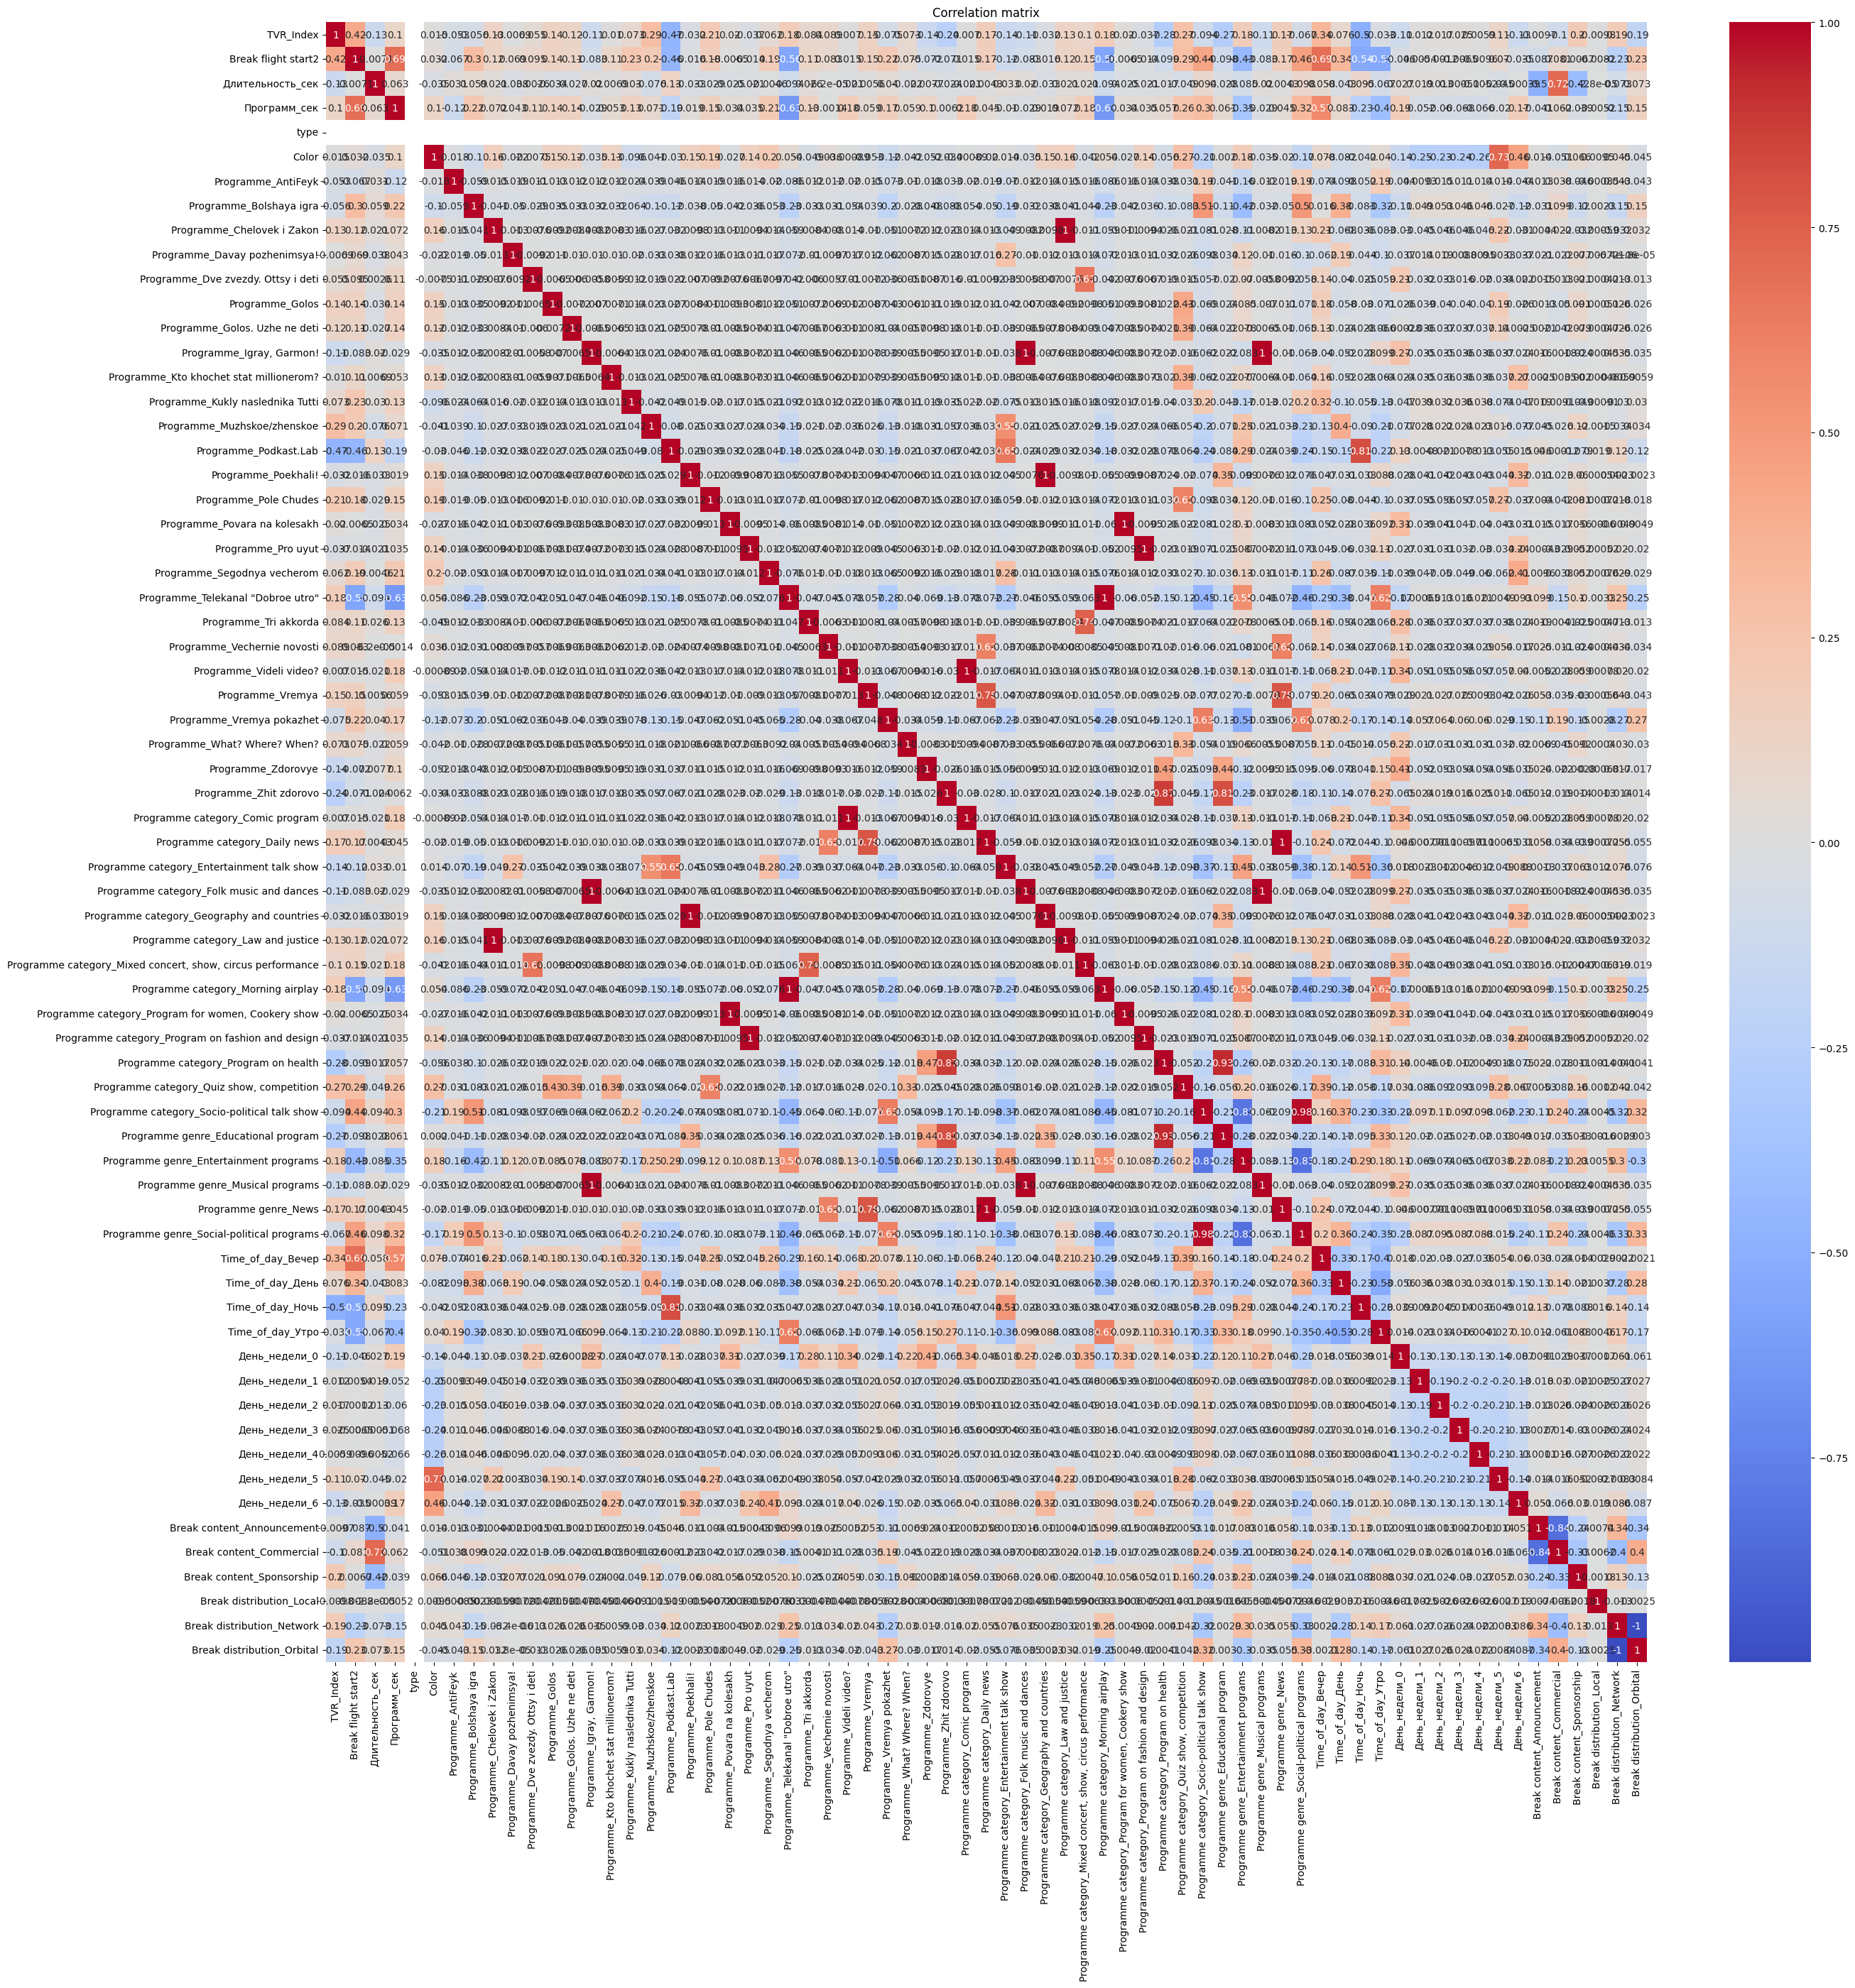

In [ ]:
# Корреляционная матрица
corr_matrix = data.corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation matrix')
plt.show()

In [ ]:
# Таблица: вывод значений коэф. корреялции всех столбцов с таргетом
pd.set_option('display.max_rows', 100)
correlation = data.corr(method = 'spearman')['TVR_Index']
correlation.head(1000)

<ipython-input-2059-be618bd1b307>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr(method = 'spearman')['TVR_Index']


TVR_Index                                                     1.000000
Break flight start2                                           0.418075
Длительность_сек                                             -0.127895
Программ_сек                                                  0.104586
type                                                               NaN
Color                                                         0.014627
Programme_AntiFeyk                                           -0.053482
Programme_Bolshaya igra                                      -0.056466
Programme_Chelovek i Zakon                                    0.126428
Programme_Davay pozhenimsya!                                 -0.006883
Programme_Dve zvezdy. Ottsy i deti                            0.054647
Programme_Golos                                               0.141359
Programme_Golos. Uzhe ne deti                                 0.115361
Programme_Igray, Garmon!                                     -0.113873
Progra

Тоже, но с сортировкой

In [ ]:
correlation = data.corr(method='spearman')['TVR_Index']
correlation = correlation.abs().sort_values(ascending=False)
correlation.head(100)

<ipython-input-2060-706b182eb1e3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr(method='spearman')['TVR_Index']


TVR_Index                                                     1.000000
Time_of_day_Ночь                                              0.498385
Programme_Podkast.Lab                                         0.471768
Break flight start2                                           0.418075
Time_of_day_Вечер                                             0.339843
Programme_Muzhskoe/zhenskoe                                   0.292744
Programme category_Program on health                          0.278303
Programme genre_Educational program                           0.272827
Programme category_Quiz show, competition                     0.267350
Programme_Zhit zdorovo                                        0.237319
Programme_Pole Chudes                                         0.205255
Break content_Sponsorship                                     0.197147
Break distribution_Network                                    0.194902
Break distribution_Orbital                                    0.194764
Progra

На основе корреляционной матрицы нужно принять решение об удалении тех или иных признаков, чтобы избежать мультиколлинеарности. Те же колонки следует удалить и из данных для прогноза (november) (критично 0,7-08, но надо смотреть насколько признаки вносят доп. инфу)

In [ ]:
data = data.drop(columns=['Programme category_Law and justice', 'Programme category_Folk music and dances', 'Programme genre_Musical programs', 'Programme category_Program for women, Cookery show', 'Programme category_Program on fashion and design', 'Programme genre_News', 'Programme category_Geography and countries', 'Programme category_Morning airplay'])
data = data.drop(columns=['Programme flight start2'])

### november.drop(['TVR Index'], axis=1)

november = november.drop(columns=['Programme category_Law and justice', 'Programme category_Folk music and dances', 'Programme genre_Musical programs', 'Programme category_Program for women, Cookery show', 'Programme category_Program on fashion and design', 'Programme genre_News', 'Programme category_Geography and countries', 'Programme category_Morning airplay'])
november = november.drop(columns=['Programme flight start2'])


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30572 entries, 0 to 33886
Data columns (total 59 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   TVR_Index                                                   30572 non-null  float64
 1   Break flight start2                                         30572 non-null  int64  
 2   Длительность_сек                                            30572 non-null  float64
 3   Программ_сек                                                30572 non-null  float64
 4   type                                                        30572 non-null  int64  
 5   Color                                                       30572 non-null  int64  
 6   Programme_AntiFeyk                                          30572 non-null  uint8  
 7   Programme_Bolshaya igra                                     30572 non-null  uint8  
 

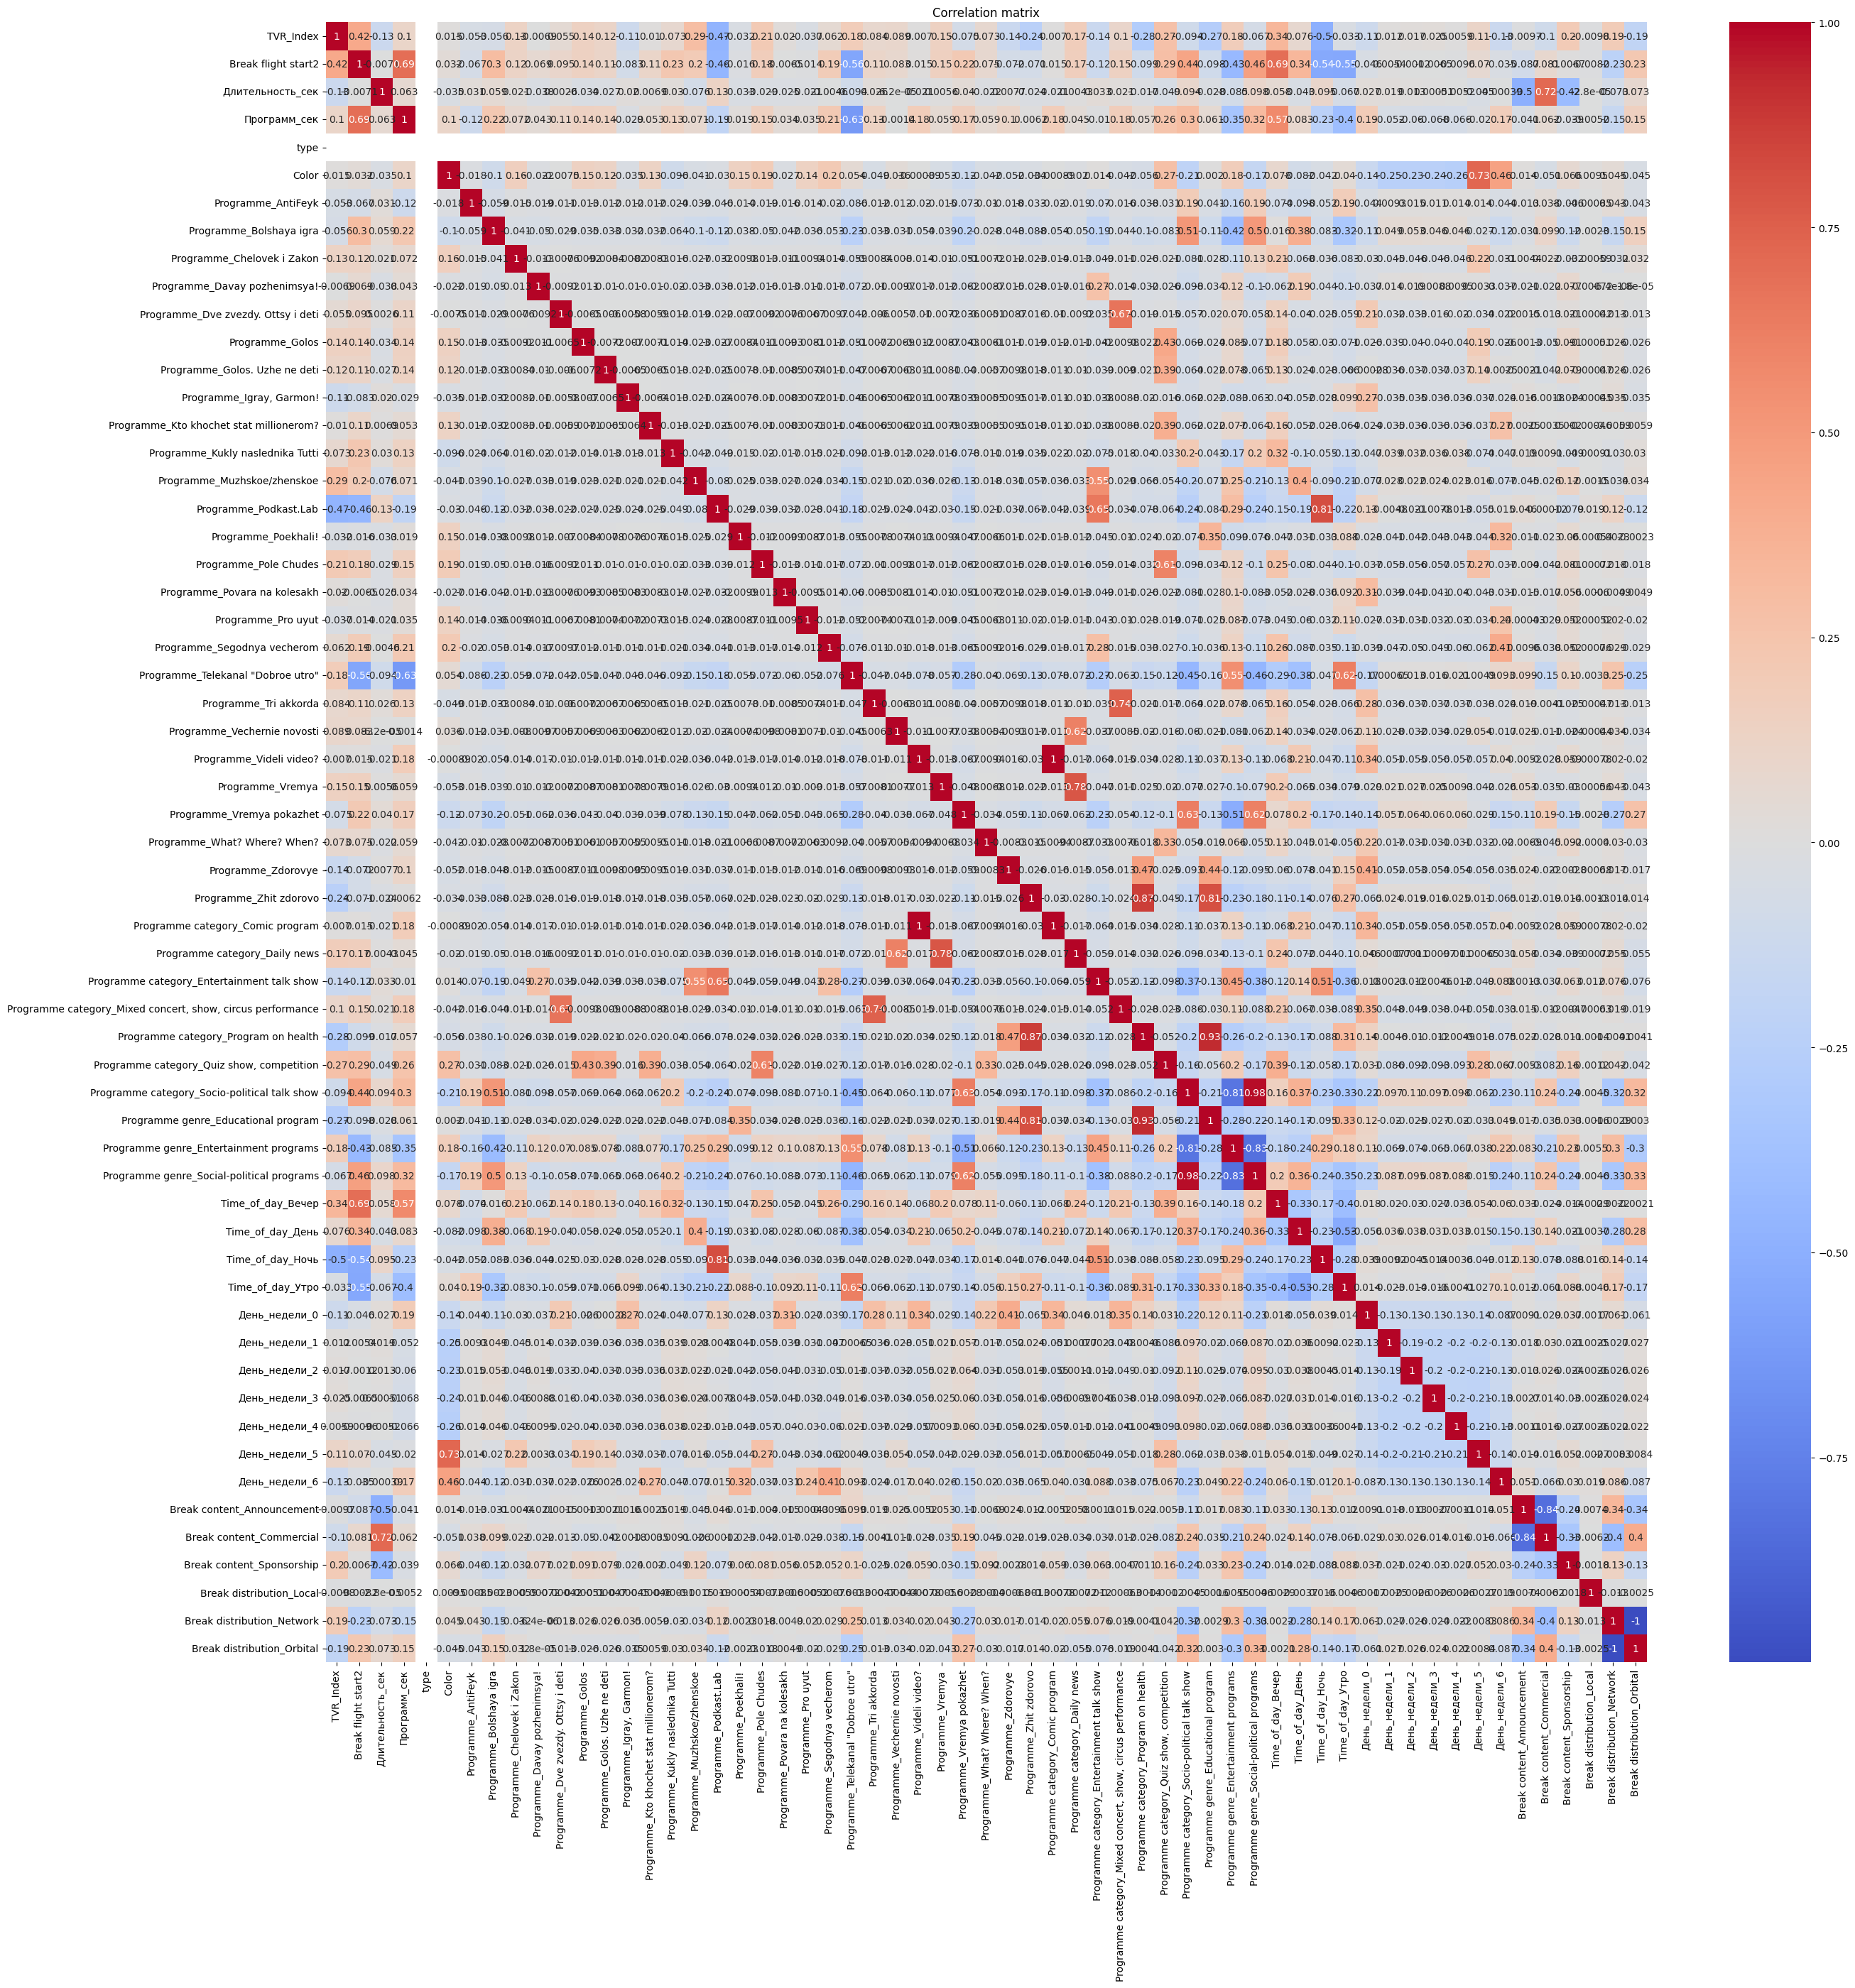

In [ ]:
# Корреляционная матрица
corr_matrix = data.corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation matrix')
plt.show()

### Выводы по разделу

ываыаыва

## Разделение выборки на обучающую и тестовую

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X = data.drop(['TVR_Index'], axis=1)
y = data['TVR_Index']

######## Добавлено семплирование, но по Таргету (stratify=y). А таргет то у нас не 2 значения. Поэтому не очень понятно что это дает

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #

#### График  целевая переменная и зависимости от признаков

In [ ]:
# Для каждого признака отображаем зависимость целевой переменной
#for feature in X.columns:
#    plt.scatter(X[feature], y)  # Отображаем график рассеяния с признаком на оси x и целевой переменной на оси y
#    plt.xlabel(feature)  # Задаем метку оси x
#    plt.ylabel('y')  # Задаем метку оси y
#    plt.show()  # Показываем график для каждого признака отдельно

### Линейная регрессия

### Линейная регрессия но со стандарт-скалер

MAPE: 0.47918132449522133


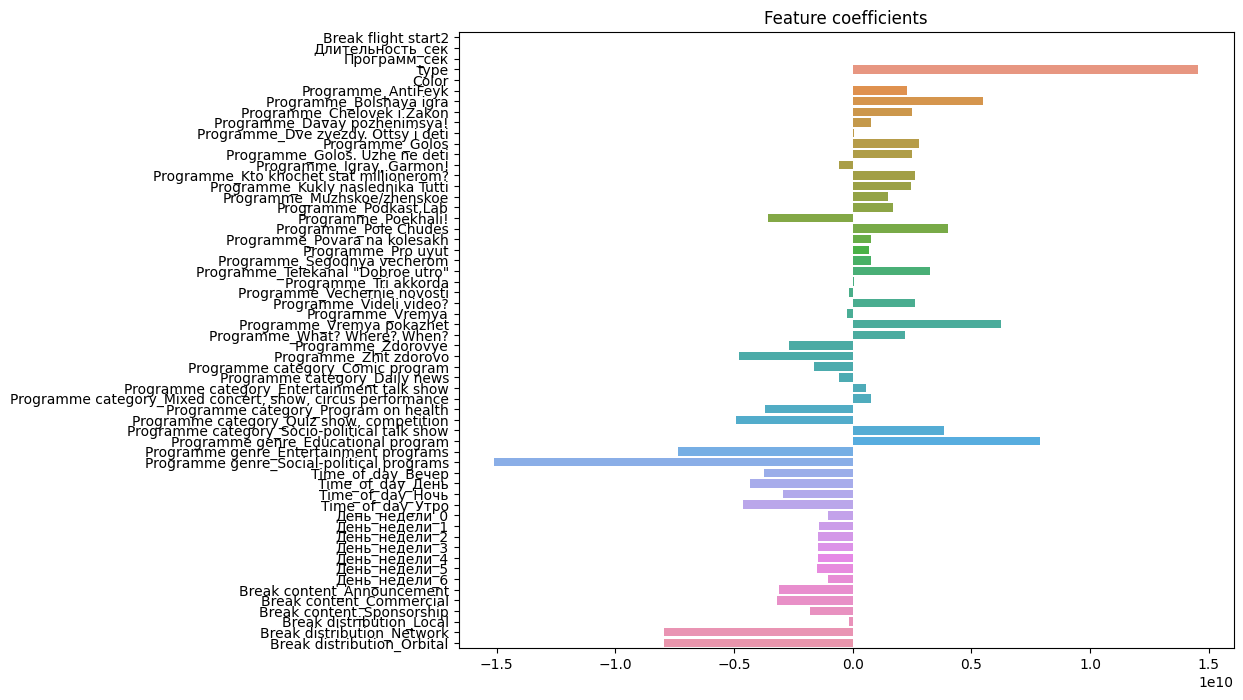

[-1.64930806e-01 -2.58714056e-02  3.43870387e-02  1.45604164e+10
 -3.32096445e-02  2.27810776e+09  5.48537684e+09  2.47940974e+09
  7.53236720e+08  3.21894756e+07  2.80266011e+09  2.49995905e+09
 -5.81470286e+08  2.62699602e+09  2.43855193e+09  1.48415319e+09
  1.70996005e+09 -3.56856479e+09  4.00247741e+09  7.82010947e+08
  6.98291540e+08  7.85572322e+08  3.24682057e+09  3.60480521e+07
 -1.74262669e+08  2.63231186e+09 -2.26471656e+08  6.25121807e+09
  2.21386213e+09 -2.70410342e+09 -4.78568854e+09 -1.61808805e+09
 -6.00767544e+08  5.46890987e+08  7.64805411e+08 -3.69404071e+09
 -4.91893668e+09  3.85087222e+09  7.89067976e+09 -7.35916163e+09
 -1.51249744e+10 -3.74669673e+09 -4.32564057e+09 -2.92974543e+09
 -4.61144356e+09 -1.06505917e+09 -1.44025345e+09 -1.46276049e+09
 -1.46504015e+09 -1.45616147e+09 -1.49612968e+09 -1.06555367e+09
 -3.09311453e+09 -3.18196165e+09 -1.78816389e+09 -1.39236064e+08
 -7.96792861e+09 -7.96709943e+09]


In [ ]:
scaler = StandardScaler()

# Масштабирование данных
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Построение и обучение модели
modelLRS = LinearRegression()
modelLRS.fit(X_train_scaled, y_train)

# Оценка качества модели на тестовой выборке
y_pred = modelLRS.predict(X_test_scaled)

MAPE = mean_absolute_percentage_error(y_test, y_pred)

#mse = mean_squared_error(y_test, y_pred)
#rmse = mse ** 0.5

print('MAPE:', MAPE)
#print('MSE:', mse)
#print('RMSE:', rmse)




fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=modelLRS.coef_, y=X_train.columns, ax=ax)
plt.title('Feature coefficients')
plt.show()


coefficients = modelLRS.coef_

print(coefficients)


### Random Forest Regressor

In [ ]:
# Построение и обучение модели
modelRF = RandomForestRegressor()
modelRF.fit(X_train, y_train)

# Оценка качества модели на тестовой выборке


y_pred = modelRF.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse ** 0.5
#print('MSE:', mse)
#print('RMSE:', rmse)
print('MAPE:', MAPE)



# Подбор гиперпараметров модели
param_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': [5, 11]}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)

### Lasso Scaled

In [ ]:
# В данном примере мы создаем модель Lasso и задаем сетку параметров для перебора.
# Затем используем GridSearchCV для поиска оптимальных параметров на обучающей выборке.
# После этого выводим наилучшие параметры и оцениваем качество модели на тестовой выборке с лучшими параметрами.

# Создание модели Lasso
modelLasS = Lasso()

# Масштабирование данных

# мы уже делали для линейной регрессии
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Задание сетки параметров для перебора
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 20], # тут еще добавил 0.001
              'max_iter': [2000]}

# Поиск оптимальных параметров с помощью GridSearchCV
grid_search = GridSearchCV(modelLasS, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Вывод наилучших параметров
print('Best parameters:', grid_search.best_params_)

# Оценка качества модели на тестовой выборке с лучшими параметрами
y_pred = grid_search.predict(X_test_scaled)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
#mse = mean_squared_error(y_test, y_pred)
# rmse = mse ** 0.5
#print('MSE:', mse)
#print('RMSE:', rmse)
print('MAPE:', MAPE)







### CatBoost Regressor

In [ ]:
# В данном примере мы создаем модель CatBoostRegressor и задаем сетку параметров для перебора.
# Затем используем GridSearchCV для поиска оптимальных параметров на обучающей выборке.
# После этого выводим наилучшие параметры и оцениваем качество модели на тестовой выборке с лучшими параметрами.

#c Для этой модели не нужно раскидывать категориный признаки, а надо указывать
# типа
#ccat_features = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'user_type', 'image_top_1']
#cat_features=cat_features

%%time

# установка катбуста - его наверно достаточно 1 раз за сеанс ставить
# !pip install catboost

from sklearn.metrics import mean_squared_error # почему-то ошибка как будто из-за отсутствия этог модуля

try:
    from catboost import CatBoostRegressor
except ImportError:
    print("Катастрофично: Catboost не установлен.")
    print("Устанавливая catboost...")

    # Пытаясь установить catboost
    !pip install catboost

    print("Catboost успешно установлен!")


# conda install -c conda-forge catboost
from catboost import CatBoostRegressor
from catboost.utils import eval_metric

# Создание модели CatBoostRegressor
modelCB = CatBoostRegressor(eval_metric='MAPE', early_stopping_rounds=20)


# Задание сетки параметров для перебора
param_grid = {
    'learning_rate': [0.1], # Меньшее число дает лучшее качество
    'depth': [7],
    'iterations': [800], # чем больше, тем лучше. Например 1000 (дефолтно 1000) - это тоже самое, что и н-эстиматор
    'l2_leaf_reg': [3],
    #'od_type': ['Iter'], # детектор перебучения - поменял на early_stopping_rounds=20 выше
    #'od_wait': [20] # если модель не дает лучших результатов эту цифру подряд, значит останавливаем

}


# Поиск оптимальных параметров с помощью GridSearchCV
grid_search = GridSearchCV(modelCB, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train,
                logging_level='Silent') #,
                #cat_features=cat_features


# Вывод наилучших параметров
print('Best parameters:', grid_search.best_params_)

# Оценка качества модели на тестовой выборке с лучшими параметрами
y_pred = grid_search.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
#mse = mean_squared_error(y_test, y_pred)
# rmse = mse ** 0.5
#print('MSE:', mse)
#print('RMSE:', rmse)
print('MAPE:', MAPE)



Best parameters: {'depth': 7, 'iterations': 800, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
MAPE: 0.21625379390854765
CPU times: user 52.9 s, sys: 3.2 s, total: 56.1 s
Wall time: 32.3 s


In [ ]:
# Штука для визуализации катбуста
#!pip install ipywidgets

# Штука для визуализации
#grid_search_result = model.grid_search(param_grid,
#                                       X=X_train,
#                                       y=y_train,
#                                       plot=True)

In [ ]:
#Для catboost по идее не надо разбивать категорийные
# их заводя так
# cat_features = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'user_type', 'image_top_1']

#А потом вписывают так
# cat_features=cat_features

###Catboost2 (с указанием категорийных переменных)

In [ ]:
# X_train2.columns

In [ ]:
#c Для этой модели не нужно раскидывать категориный признаки, а надо указывать
# типа
#cat_features = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'user_type', 'image_top_1']
#cat_features=cat_features

#%%time

#from sklearn.metrics import mean_squared_error # почему-то ошибка как будто из-за отсутствия этог модуля
# установка катбуста - его наверно достаточно 1 раз за сеанс ставить
# !pip install catboost


#try:
#    from catboost import CatBoostRegressor
#except ImportError:
#    print("Катастрофично: Catboost не установлен.")
#    print("Устанавливая catboost...")

    # Пытаясь установить catboost
 #   !pip install catboost

#    print("Catboost успешно установлен!")


# conda install -c conda-forge catboost
#from catboost import CatBoostRegressor
#from catboost.utils import eval_metric

#cat_features= ['Programme', 'Programme category', 'Programme category', 'Time_of_day', 'День_недели']


# Создание модели CatBoostRegressor
#modelCB2 = CatBoostRegressor(eval_metric='RMSE', early_stopping_rounds=20, cat_features=cat_features)


# Задание сетки параметров для перебора
#param_grid = {
#    'learning_rate': [0.01, 0.1, 1], # Меньшее число дает лучшее качество
#    'depth': [6, 8, 10],
#    'iterations': [100, 200, 300], # чем больше, тем лучше. Например 1000 (дефолтно 1000) - это тоже самое, что и н-эстиматор
#    'l2_leaf_reg': [1, 3, 5, 7, 9],
#    #'od_type': ['Iter'], # детектор перебучения - поменял на early_stopping_rounds=20 выше
#    #'od_wait': [20] # если модель не дает лучших результатов эту цифру подряд, значит останавливаем

#}


# Поиск оптимальных параметров с помощью GridSearchCV
#grid_search2 = GridSearchCV(modelCB2, param_grid=param_grid, cv=5)
#grid_search2.fit(X_train2, y_train2,
#                logging_level='Silent') #,



# Вывод наилучших параметров
#print('Best parameters:', grid_search2.best_params_)

# Оценка качества модели на тестовой выборке с лучшими параметрами
#y_pred2 = grid_search2.predict(X_test2)

#mse = mean_squared_error(y_test2, y_pred2)
#rmse = mse ** 0.5
#print('MSE:', mse)
#print('RMSE:', rmse)


### Проверка модели на адекватность

In [ ]:
# Создаем объект модели DummyRegressor
dummy_model = DummyRegressor()

# Выделяем признаки X и целевую переменную y

# Выполняем перекрестную проверку адекватности модели
cross_val_scores = cross_val_score(dummy_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Выводим среднее значение ошибки
mean_squared_error = -cross_val_scores.mean()
print(f"mse: Mean Squared Error: {mean_squared_error}")
print(f"RMSE: {mean_squared_error**0.5}")

mse: Mean Squared Error: 0.3669287988239335
RMSE: 0.6057464806533617


## Применение модели для прогнозирования рейтинга рекламных блоков в ноябре 2023 года

In [ ]:
#november2 = pd.read_excel('https://hr-portal.ru/files/my_test.xlsx')

In [ ]:
# november2.head()

Date  Break flight ID Break flight start Break flight end  \
0 2023-11-01       5336499245           05:18:36         05:19:07   
1 2023-11-01       5336499246           05:25:51         05:27:00   
2 2023-11-01       5336499251           05:49:11         05:50:04   
3 2023-11-01       5336499255           06:09:24         06:12:29   
4 2023-11-01       5336499270           06:12:35         06:13:46   

  Break content Break distribution                Programme  \
0  Announcement            Network  Telekanal "Dobroe utro"   
1  Announcement            Network  Telekanal "Dobroe utro"   
2  Announcement            Network  Telekanal "Dobroe utro"   
3    Commercial            Network  Telekanal "Dobroe utro"   
4  Announcement            Network  Telekanal "Dobroe utro"   

  Programme flight start Programme flight end Programme category  \
0               05:06:18             05:30:15    Morning airplay   
1               05:06:18             05:30:15    Morning airplay   
2               05:36:16             06:00:15    Morning airplay   
3               06:06:19             06:30:15    Morning airplay   
4               06:06:19             06:30:15    Morning airplay   

          Programme genre  TVR Index Forecast  
0  Entertainment programs                 NaN  
1  Entertainment programs                 NaN  
2  Entertainment programs                 NaN  
3  Entertainment programs                 NaN  
4  Entertainment programs                 NaN

### Пробуем Рандом форест

In [ ]:
new_features = november.drop(['TVR_Index'], axis=1)
# 1. Масштабировать выборку
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_new_scaled = scaler.transform(new_features)

# 2. Создать модель с лучшими параметрами
best_model = RandomForestRegressor(max_depth=11, n_estimators=50)

# 3. Обучить модель на всей выборке
best_model.fit(X_scaled, y)

# 4. Масштабировать новые данные
new_features_scaled = scaler.transform(new_features)

# 5. Выполнить предсказание на новых данных
y_new = best_model.predict(X_new_scaled)
november['TVR Index Forecast'] = y_new

november.head()

TVR_Index  Break flight start2  Длительность_сек  Программ_сек  type  \
0        NaN                19080              31.0        1437.0     0   
1        NaN                19500              69.0        1437.0     0   
2        NaN                20940              53.0        1439.0     0   
3        NaN                22140             185.0        1436.0     0   
4        NaN                22320              71.0        1436.0     0   

   Color  Programme_AntiFeyk  Programme_Bolshaya igra  \
0      1                   0                        0   
1      1                   0                        0   
2      1                   0                        0   
3      1                   0                        0   
4      1                   0                        0   

   Programme_Chelovek i Zakon  Programme_Davay pozhenimsya!  ...  \
0                           0                             0  ...   
1                           0                             0  ...   
2                           0                             0  ...   
3                           0                             0  ...   
4                           0                             0  ...   

   День_недели_4  День_недели_5  День_недели_6  Break content_Announcement  \
0              0              0              0                           1   
1              0              0              0                           1   
2              0              0              0                           1   
3              0              0              0                           0   
4              0              0              0                           1   

   Break content_Commercial  Break content_Sponsorship  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         1                          0   
4                         0                          0   

   Break distribution_Local  Break distribution_Network  \
0                         0                           1   
1                         0                           1   
2                         0                           1   
3                         0                           1   
4                         0                           1   

   Break distribution_Orbital  TVR Index Forecast  
0                           0            0.207075  
1                           0            0.251359  
2                           0            0.475601  
3                           0            1.054237  
4                           0            1.074862  

[5 rows x 60 columns]

In [ ]:
november.to_excel('predictions.xlsx', index=False)

### Пробуем линейной регрессией

In [ ]:
X

In [ ]:
# november.to_csv('predictions.csv', index=False)




In [ ]:

new_features = november.drop(['TVR_Index'], axis=1)
# 1. Масштабировать выборку
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_new_scaled = scaler.transform(new_features)

# 2. Создать модель с лучшими параметрами
best_model = LinearRegression()

# 3. Обучить модель на всей выборке
best_model.fit(X_scaled, y)

# 4. Масштабировать новые данные
new_features_scaled = scaler.transform(new_features)

# 5. Выполнить предсказание на новых данных
y_new = best_model.predict(X_new_scaled)
# november['TVR Index'] = y_new

In [ ]:
# november

### Пробуем catboost

In [ ]:
modelCB = CatBoostRegressor(depth=10, iterations=100, learning_rate=0.01)
#Тут важно, что когда мы учим на всем датасете, то надо увеличить кол-во итераций, иначе модель недобучиться
# данные то стало больше. Примерно коэффициент 1.2 - инфа от Дорогуш
modelCB.fit(X, y) # поменял на просто Х и y

# Здесь X_train - тренировочная выборка с признаками, а y_train - целевая переменная.
# не понял, зачем мы опять учим на трейн, может лучше на всей исторической выборке data?
#2. Примените обученную модель для заполнения прогнозируемых значений в колонку "y" (целевую переменную) в вашем датасете:

new_features = november.drop('TVR Index', axis=1)
y_pred = modelCB.predict(new_features) # новембер тут новые фичи
november['TVR Index'] = y_pred

#Здесь X_dataset представляет собой ваш датасет, в котором нужно заполнить колонку "y" с прогнозируемыми значениями.

#Обратите внимание, что перед заполнением прогнозируемых значений в колонку "y",
# убедитесь, что данные в X_dataset подготовлены в соответствии с требованиями модели CatBoostRegressor (например, кодирование категориальных признаков, масштабирование и т.д.).

In [ ]:
november

### Пробуем стеккинг. Знать бы еще как его использовать

In [ ]:
from catboost import CatBoostClassifier
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric= 'AUC:hints=skip_train~false',
    metric_period=2000,
    random_seed=42,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
    bootstrap_type='Bernoulli'
)
stacking = StackingClassifier(
    estimators=[
        ("modelLRS", modelLRS),
        ("modelLasS", modelLasS),
        ("modelRF", modelRF),
        ("modelCB", modelCB)
    ],
    final_estimator=meta,
    n_jobs=-1,
)
stacking.fit(X_train, y_train)

from catboost import CatBoostRegressor
meta = CatBoostRegressor(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
)
stacking = StackingClassifier(
    estimators=[
        ("modelLRS", modelLRS),   
        ("modelLasS", modelLasS),
        ("modelRF", modelRF),
        ("modelCB", modelCB)
    ],
    final_estimator=meta,
    n_jobs=-1,
)
stacking.fit(X_train, y_train)

Проверяем адекватность модели

## Моделируем определение длительности передачи

Пока не очень понятно в каком виде будут даны данные

### Вариант 1. У нас есть список передач и время начало каждой

In [ ]:
# Загрузка данных
try:
  #time = pd.read_csv('time.csv', sep=';')
  time = pd.read_csv('time.csv', sep=';')
except:
  time = pd.read_csv('https://hr-portal.ru/files/time.csv', sep=';')
time.head(12)

In [ ]:
# df['time'] = df['time'].fillna(0)

In [ ]:
# удаляем строку с индексом 9
#time = time.drop(9)
#time

In [ ]:
time.info()

In [ ]:
time.head()

In [ ]:
time['Time_start'] = pd.to_datetime(time['Time_start'], format='%H:%M:%S')
time['Время_начала_РБ'] = pd.to_datetime(time['Время_начала_РБ'], format='%H:%M:%S')
time.info()


In [ ]:
time.head()

In [ ]:
time['diff'] = time['Time_start'] - time['Time_start'].shift(1)

# Set the first difference to be the same as the second value
time.loc[0, 'diff'] = time.loc[1, 'Time_start'] - time.loc[0, 'Time_start']

# Fill NaN values with 0 seconds
#time['diff'] = time['diff'].fillna(pd.Timedelta(seconds=0))




# заменяем значение diff для первой строки на NaN
# time.loc[time.index[0], 'diff'] = None
time

In [ ]:
time['diff'] = (time['diff'] / pd.Timedelta(seconds=1)).astype('int64')
time

In [ ]:
# вычисляем медиану колонки diff и добавляем ее в конец колонки diff
# median_diff = time['diff'].median()
# time.loc[len(time)] = [None, median_diff - time['diff'].iloc[-1]]

# time

## Функция определения когда в передаче показали рекламный блок

Функция, которая определяет, когда показывали рекламный блок относительно программы (в начале, середине или конце), и заполняет это значение в колонку "Когда показали РБ":


В этой функции мы проходимся по каждой строке в DataFrame df. Затем вычисляем середину времени показа программы (time_middle) путем деления разности времени показа на 2. Затем сравниваем время начала показа рекламного блока (time_ad_start) с временем начала программы (time_start) и временем середины программы (time_middle) и записываем соответствующее значение в колонку "Когда показали РБ".


In [ ]:

def determine_ad_placement(df):
    df['Когда показали РБ'] = ""

    for index, row in df.iterrows():
        time_start = row['Time_start']
        diff = row['diff']
        time_ad_start = row['Время_начала_РБ']

        time_middle = time_start + pd.Timedelta(seconds=diff) / 2

        if time_ad_start <= time_start:
            df.at[index, 'Когда показали РБ'] = "в начале программы"
        elif time_ad_start > time_middle:
            df.at[index, 'Когда показали РБ'] = "в конце программы"
        else:
            df.at[index, 'Когда показали РБ'] = "в середине программы"

    return df

In [ ]:
determine_ad_placement(time)